The data came from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524 --> GSE171524_RAW.tar file

## Integration

Only necessary if you are runing an analysis with multiple samples. The experiment sampled 19 COVID-19 patients and 7 control patients. There are a total of 26 samples in this analysis, thus, integration is necessary.

We are essentially gonna now do the same thing as we did for (1) loading the data, (2) doublet removal, (3) preprocessing, and (4) Clustering.
However, we will do this for all samples, to make this more efficient, we made this into a function and have the function iterate through each sample file.

In [1]:
import gc  # Import garbage collector
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
import os

def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft=False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 0.25)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2]
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    sc.pp.filter_cells(adata, min_genes=200)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    
    ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
    ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]
    
    return adata

c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
out = []
for file in os.listdir('GSE171524_RAW_mini/'):
    processed_data = pp('GSE171524_RAW_mini/' + file)
    out.append(processed_data)
    
    # Clear memory
    del processed_data
    gc.collect()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [15:18<00:00,  2.29s/it, v_num=1, train_loss_step=324, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [15:18<00:00,  2.30s/it, v_num=1, train_loss_step=324, train_loss_epoch=323]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 217/400:  54%|█████▍    | 217/400 [01:25<01:12,  2.54it/s, v_num=1, train_loss_step=0.176, train_loss_epoch=0.292]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.281. Signaling Trainer to stop.


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [11:29<00:00,  1.69s/it, v_num=1, train_loss_step=389, train_loss_epoch=395]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [11:29<00:00,  1.72s/it, v_num=1, train_loss_step=389, train_loss_epoch=395]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 246/400:  62%|██████▏   | 246/400 [01:09<00:43,  3.55it/s, v_num=1, train_loss_step=0.19, train_loss_epoch=0.295] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.291. Signaling Trainer to stop.


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [17:57<00:00,  2.64s/it, v_num=1, train_loss_step=365, train_loss_epoch=334]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [17:57<00:00,  2.69s/it, v_num=1, train_loss_step=365, train_loss_epoch=334]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 235/400:  59%|█████▉    | 235/400 [01:40<01:10,  2.33it/s, v_num=1, train_loss_step=0.458, train_loss_epoch=0.311]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.301. Signaling Trainer to stop.


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [06:18<00:00,  1.07it/s, v_num=1, train_loss_step=454, train_loss_epoch=416]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:18<00:00,  1.06it/s, v_num=1, train_loss_step=454, train_loss_epoch=416]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 370/400:  92%|█████████▎| 370/400 [00:58<00:04,  6.34it/s, v_num=1, train_loss_step=0.354, train_loss_epoch=0.324]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.328. Signaling Trainer to stop.


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [08:40<00:00,  1.29s/it, v_num=1, train_loss_step=187, train_loss_epoch=317]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:40<00:00,  1.30s/it, v_num=1, train_loss_step=187, train_loss_epoch=317]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 196/400:  49%|████▉     | 196/400 [00:42<00:43,  4.64it/s, v_num=1, train_loss_step=0.388, train_loss_epoch=0.301]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.302. Signaling Trainer to stop.


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

Epoch 400/400: 100%|██████████| 400/400 [17:28<00:00,  2.57s/it, v_num=1, train_loss_step=400, train_loss_epoch=340]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [17:28<00:00,  2.62s/it, v_num=1, train_loss_step=400, train_loss_epoch=340]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 199/400:  50%|████▉     | 199/400 [01:22<01:23,  2.41it/s, v_num=1, train_loss_step=0.361, train_loss_epoch=0.309]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.308. Signaling Trainer to stop.


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\preprocessing\_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"

In [3]:
adata = sc.concat(out)

In [4]:
adata

AnnData object with n_obs × n_vars = 29379 × 34546
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [5]:
sc.pp.filter_genes(adata, min_cells=10)

In [6]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
from scipy.sparse import csr_matrix

In [8]:
adata.X = csr_matrix(adata.X) #help compress the data for memory efficiency

In [9]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 25907810 stored elements and shape (29379, 25284)>

In [10]:
adata.write_h5ad('combined.h5ad')

Once the data is now saved into the hard drive. You can restart the Kernel and clear up cached memory to process the rest of the analysis without memory error.

In [1]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad('combined.h5ad')
adata

AnnData object with n_obs × n_vars = 29379 × 25284
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [3]:
adata.obs.groupby('Sample').count()

C:\Users\agarc\AppData\Local\Temp\ipykernel_10308\2340059915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


doublet  n_genes  n_genes_by_counts  total_counts  \
Sample                                                               
mini/GSM5226574     5960     5960               5960          5960   
mini/GSM5226575     4415     4415               4415          4415   
mini/GSM5226576     6928     6928               6928          6928   
mini/GSM5226598     2429     2429               2429          2429   
mini/GSM5226599     3257     3257               3257          3257   
mini/GSM5226600     6390     6390               6390          6390   

                 total_counts_mt  pct_counts_mt  total_counts_ribo  \
Sample                                                               
mini/GSM5226574             5960           5960               5960   
mini/GSM5226575             4415           4415               4415   
mini/GSM5226576             6928           6928               6928   
mini/GSM5226598             2429           2429               2429   
mini/GSM5226599             3257           3257               3257   
mini/GSM5226600             6390           6390               6390   

                 pct_counts_ribo  
Sample                            
mini/GSM5226574             5960  
mini/GSM5226575             4415  
mini/GSM5226576             6928  
mini/GSM5226598             2429  
mini/GSM5226599             3257  
mini/GSM5226600             6390

There are still over 25,000 genes so we will cut out some unecessary genes using mininum amount of cells.

In [4]:
sc.pp.filter_genes(adata, min_cells=100)

In [5]:
adata #now there are 16471 genes

AnnData object with n_obs × n_vars = 29379 × 16471
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

Integration via SCVI

In [6]:
#save the raw data into 'counts' layer
adata.layers['counts'] = adata.X.copy()

In [7]:
#normalize the counts to 10,000 to every cell.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [8]:
adata.obs.head()

Sample  doublet  n_genes  n_genes_by_counts  \
CGTTCTGGTACTAGCT-1_1  mini/GSM5226574    False     2434               2434   
CTGGCAGGTTCGGTAT-1_1  mini/GSM5226574    False     2444               2444   
ACACCAACACAACGCC-1_1  mini/GSM5226574    False     2451               2451   
CCTCAACCATACAGGG-1_1  mini/GSM5226574    False     2276               2276   
ACAAAGATCCACAGGC-1_1  mini/GSM5226574    False     2310               2310   

                      total_counts  total_counts_mt  pct_counts_mt  \
CGTTCTGGTACTAGCT-1_1        6047.0              0.0            0.0   
CTGGCAGGTTCGGTAT-1_1        5899.0              0.0            0.0   
ACACCAACACAACGCC-1_1        5497.0              0.0            0.0   
CCTCAACCATACAGGG-1_1        5434.0              0.0            0.0   
ACAAAGATCCACAGGC-1_1        5504.0              0.0            0.0   

                      total_counts_ribo  pct_counts_ribo  
CGTTCTGGTACTAGCT-1_1                1.0         0.016537  
CTGGCAGGTTCGGTAT-1_1                5.0         0.084760  
ACACCAACACAACGCC-1_1                3.0         0.054575  
CCTCAACCATACAGGG-1_1                0.0         0.000000  
ACAAAGATCCACAGGC-1_1                1.0         0.018169

In [9]:
adata # the number of cells (29379) is much higher than the number of genes (16471). Thus, no need to filter out genes.

AnnData object with n_obs × n_vars = 29379 × 16471
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

You generally want to have roughly have the number of genes to the number of cells. Cells (28379) can be rounded to 30,000; and Genes (16471) can be rounded to 15,000. Which is good to continue without filtering genes.

However, if you need to filter genes follow the following code.

In [10]:
#import math
#def highly_var_genes(top_gene_count):
#    sc.pp.highly_variable_genes(adata, n_top_genes=top_gene_count, subset=True, layer='counts',
#                            flavor='seurat_v3', batch_key="Sample") # no batch key needed if only one sample.
#gene_count = math.ceil((len(adata.obs))/2)
#highly_var_genes(gene_count)

In [11]:
scvi.model.SCVI.setup_anndata(adata, layer='counts',
                              categorical_covariate_keys=["Sample"], #add "batch" if pre-processed in batches; "technology" if pre-processed from multiple computers.
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [12]:
model = scvi.model.SCVI(adata)

In [13]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 272/272: 100%|██████████| 272/272 [6:19:49<00:00, 83.50s/it, v_num=1, train_loss_step=2.97e+3, train_loss_epoch=2.86e+3]  

`Trainer.fit` stopped: `max_epochs=272` reached.


Epoch 272/272: 100%|██████████| 272/272 [6:19:49<00:00, 83.78s/it, v_num=1, train_loss_step=2.97e+3, train_loss_epoch=2.86e+3]


In [14]:
model.get_latent_representation().shape

(29379, 10)

We will use this model for Clustering and UMAP

In [15]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [16]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)

### Clustering: Neighbors Algorithm

In [17]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [18]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

C:\Users\agarc\AppData\Local\Temp\ipykernel_10308\4044276676.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


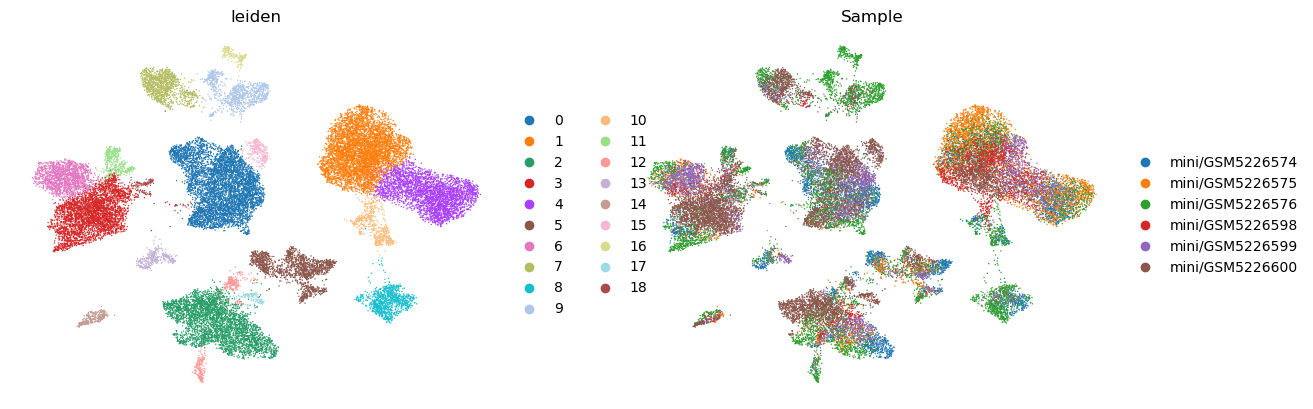

In [19]:
sc.pl.umap(adata, color=['leiden','Sample'], frameon=False)

In [20]:
adata.write_h5ad('integrated.h5ad')

### Find Markers / Label Cell Types

In [21]:
# Get the marker genes based on the leiden model and the raw data saved.

sc.tl.rank_genes_groups(adata, 'leiden')

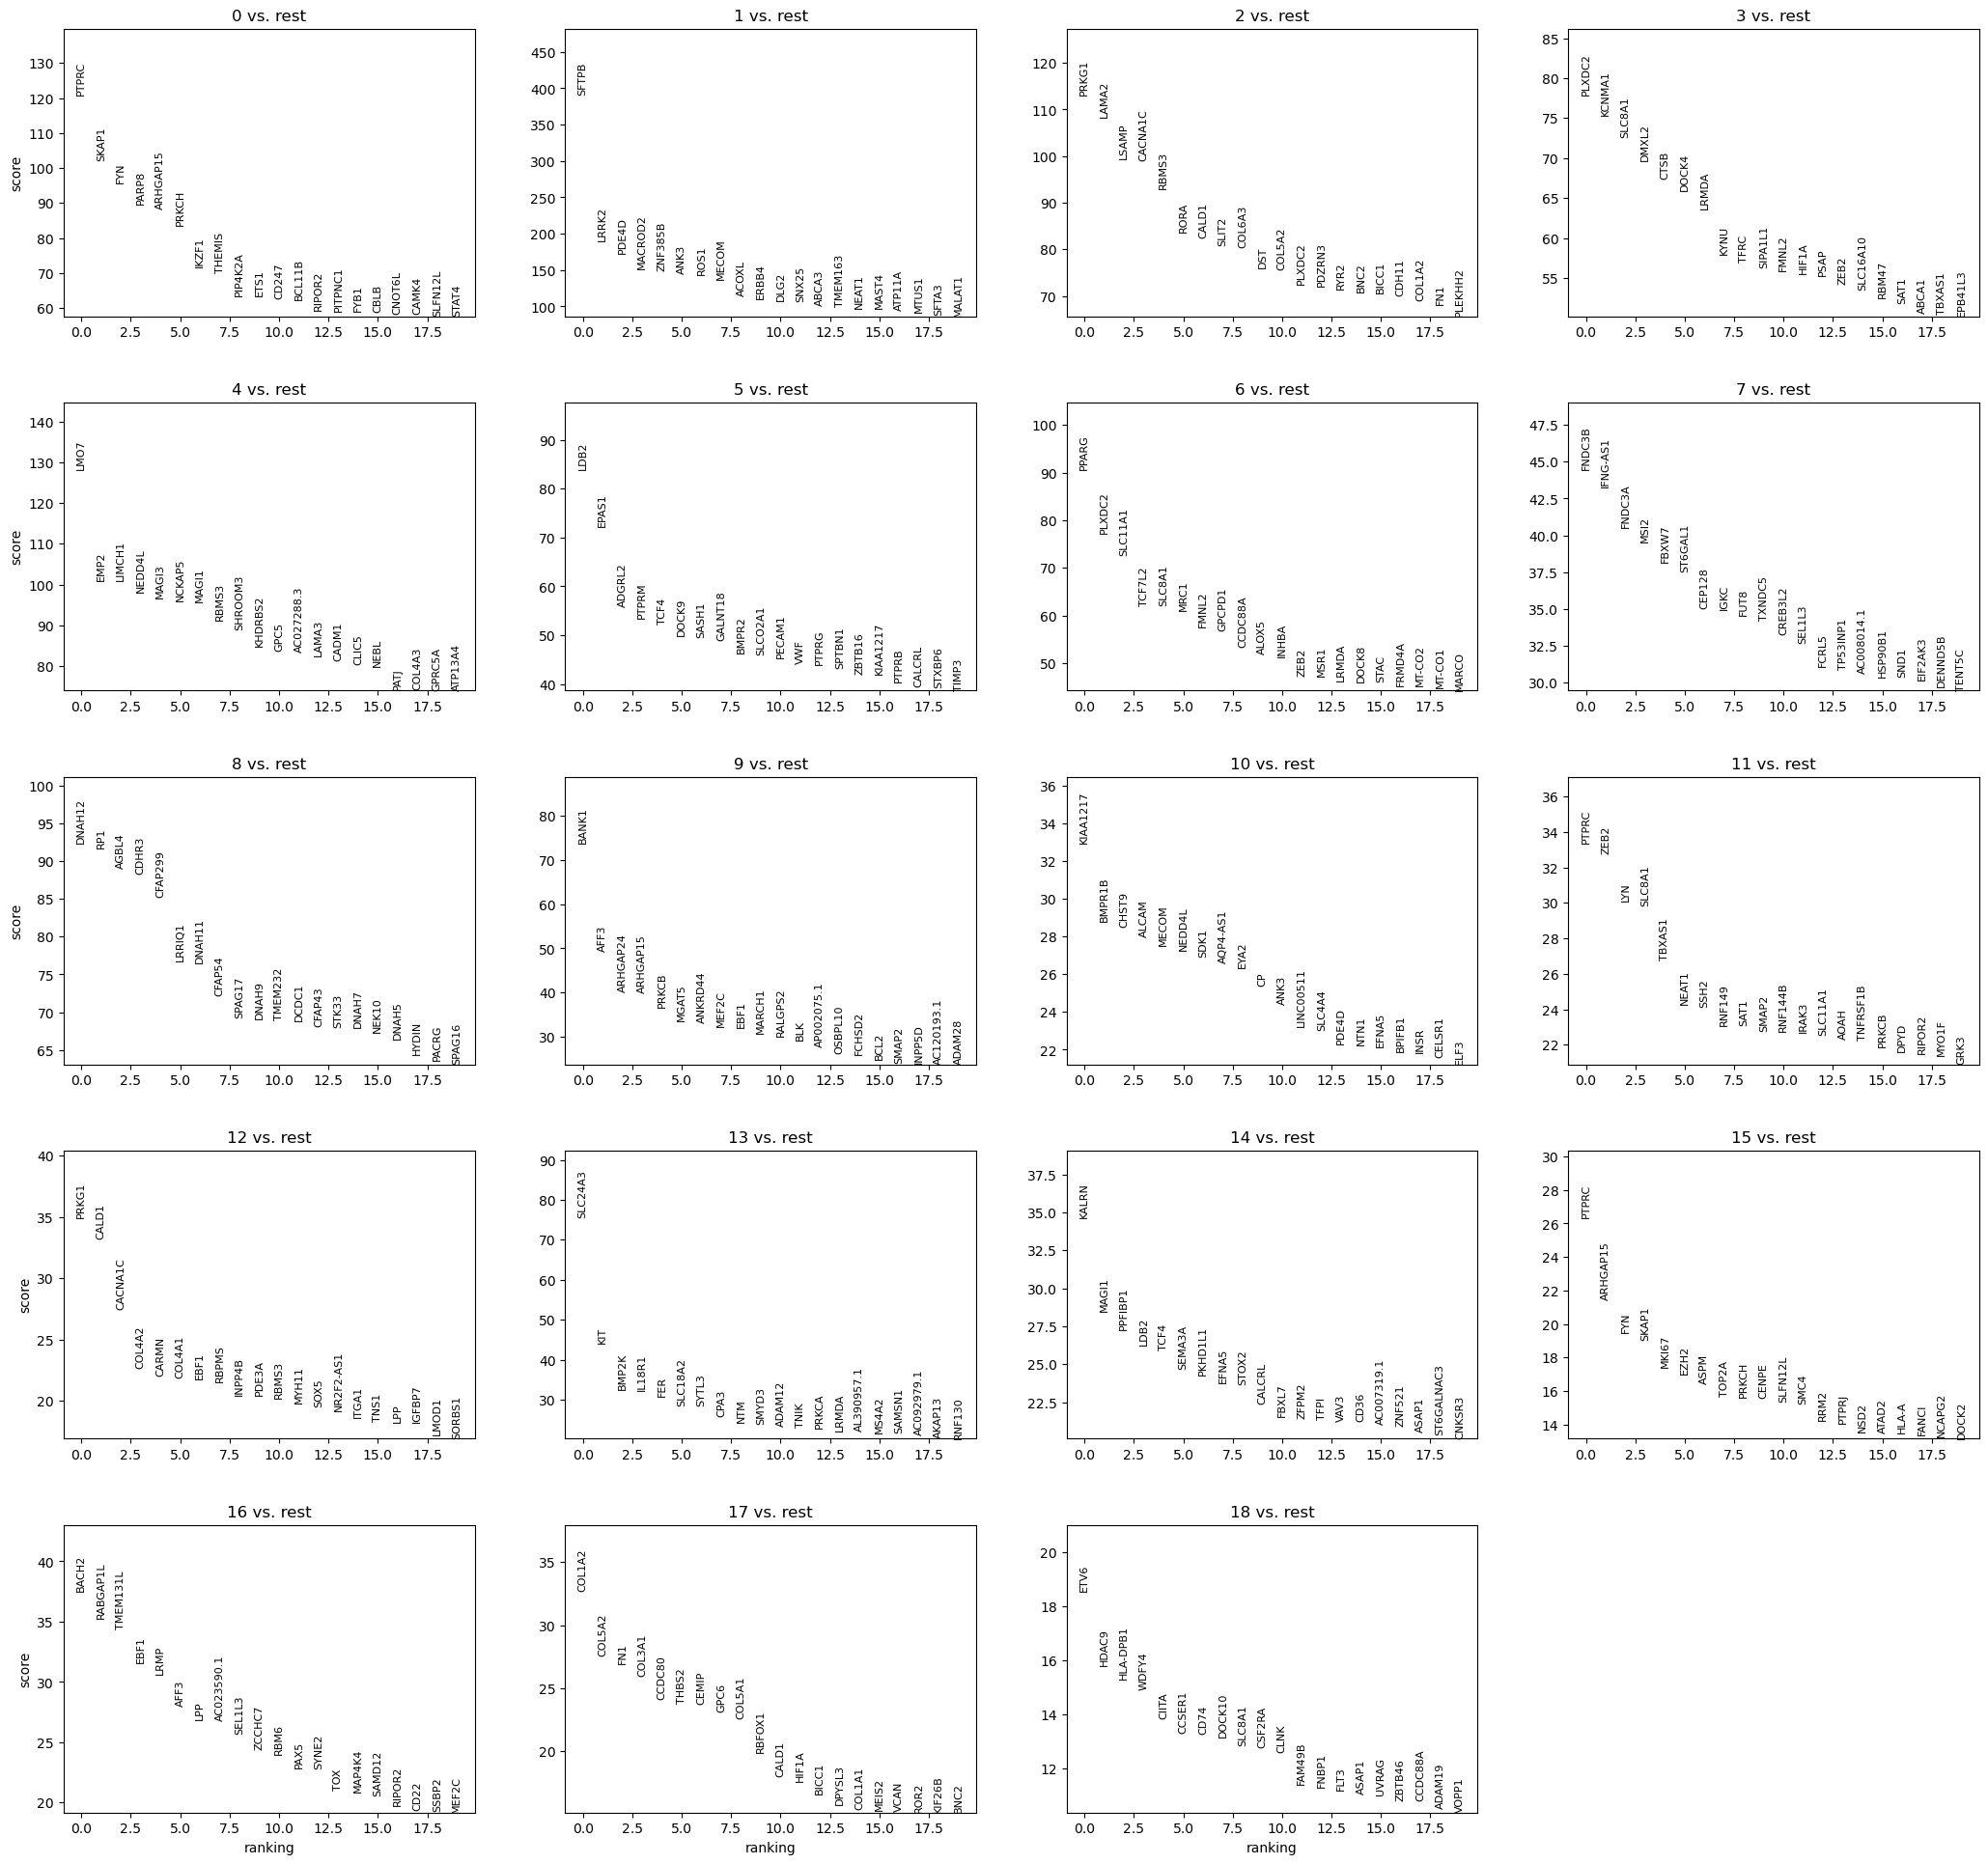

In [22]:
#plot the top 20 marker genes.

sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [23]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
markers

group     names      scores  logfoldchanges     pvals  pvals_adj
0          0     PTPRC  120.844658        4.610943  0.000000   0.000000
1          0     SKAP1  102.029663        6.346538  0.000000   0.000000
2          0       FYN   95.702705        4.791470  0.000000   0.000000
3          0     PARP8   89.653625        4.185264  0.000000   0.000000
4          0  ARHGAP15   88.344818        3.863889  0.000000   0.000000
...      ...       ...         ...             ...       ...        ...
297448    18    DTNBP1    2.311596        0.949153  0.022376   0.048847
297449    18    SYNGR2    2.307959        1.986120  0.022590   0.049292
297450    18    LRPPRC    2.306244        0.916433  0.022682   0.049484
297451    18      SCO2    2.305750        1.876938  0.022715   0.049543
297452    18     HCLS1    2.305318        1.078253  0.022737   0.049583

[45401 rows x 6 columns]

In [24]:
# calling the differential expression from the model and grouping by leiden.

markers_scvi = model.differential_expression(groupby='leiden')
markers_scvi

DE...: 100%|██████████| 19/19 [07:35<00:00, 23.98s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
ITK         0.9992        0.0008      7.130086  6.277744e-04  0.000021   
METTL7A     0.9982        0.0018      6.318161  5.195923e-07  0.000042   
DUSP1       0.9976        0.0024      6.029880  4.937164e-06  0.000273   
JDP2        0.9976        0.0024      6.029880  1.161662e-06  0.000091   
TBC1D12     0.9976        0.0024      6.029880  2.045596e-06  0.000084   
...            ...           ...           ...           ...       ...   
NPLOC4      0.5890        0.4110      0.359833  1.198683e-04  0.000116   
NCOA6       0.5730        0.4270      0.294102  1.241850e-04  0.000122   
MON2        0.5690        0.4310      0.277772  2.611219e-04  0.000287   
FNBP4       0.5410        0.4590      0.164369  2.235645e-04  0.000231   
PAFAH1B1    0.5392        0.4608      0.157122  3.397810e-04  0.000322   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
ITK                0.0   0.25  6.240619    6.279154  2.157563  ...   0.521572   
METTL7A            0.0   0.25 -8.345284   -8.531033  3.237896  ...   0.000000   
DUSP1              0.0   0.25 -7.810771   -7.978165  3.149014  ...   0.002504   
JDP2               0.0   0.25 -7.725936   -7.920881  2.865974  ...   0.001541   
TBC1D12            0.0   0.25 -6.180010   -6.214573  1.893339  ...   0.000963   
...                ...    ...       ...         ...       ...  ...        ...   
NPLOC4             0.0   0.25  0.081029    0.066780  0.493642  ...   0.130769   
NCOA6              0.0   0.25  0.049243    0.032299  0.481633  ...   0.169231   
MON2               0.0   0.25 -0.084808   -0.082499  0.488934  ...   0.430769   
FNBP4              0.0   0.25 -0.003721   -0.009492  0.424388  ...   0.423077   
PAFAH1B1           0.0   0.25  0.088655    0.098575  0.431531  ...   0.484615   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
ITK        0.012114               0.357666               0.009220   
METTL7A    0.047133               0.000000               0.039649   
DUSP1      0.419062               0.002119               0.266631   
JDP2       0.155541               0.000963               0.093935   
TBC1D12    0.119442               0.000963               0.101046   
...             ...                    ...                    ...   
NPLOC4     0.155321               0.100000               0.134261   
NCOA6      0.166773               0.146154               0.142808   
MON2       0.416702               0.315385               0.306199   
FNBP4      0.325564               0.315385               0.256453   
PAFAH1B1   0.470133               0.346154               0.339225   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
ITK                   7.057954              0.106930            True   
METTL7A               0.000000              0.304633            True   
DUSP1                 0.019500              2.713956            True   
JDP2                  0.011151              1.006492            True   
TBC1D12               0.009744              0.810794            True   
...                        ...                   ...             ...   
NPLOC4                0.668367              1.131555           False   
NCOA6                 1.495852              1.233194           False   
MON2                  3.091919              3.230636           False   
FNBP4                 2.686201              2.531531           False   
PAFAH1B1              3.171919              3.575375           False   

          comparison  group1 group2  
ITK        0 vs Rest       0   Rest  
METTL7A    0 vs Rest       0   Rest  
DUSP1      0 vs Rest       0   Rest  
JDP2       0 vs Rest       0   Rest  
TBC1D12    0 vs Rest       0   Rest  
...              ...     ...    ...  
NPLOC4    18 vs Rest      18   Rest  
NCOA6     18 vs Rest      18   Rest  
MON2      18 vs Rest      18   Rest  
FNBP4     18 vs Rest      18   Rest  
PAFAH1B1  18 vs Rest      18   Rest 

In [25]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > 0.5)]
markers_scvi

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
ITK           0.9992        0.0008      7.130086  0.000628  0.000021   
SH2D2A        0.9974        0.0026      5.949637  0.000093  0.000003   
CD3G          0.9972        0.0028      5.875328  0.000090  0.000004   
BCL11B        0.9972        0.0028      5.875328  0.000949  0.000028   
LINC01934     0.9972        0.0028      5.875328  0.000592  0.000021   
...              ...           ...           ...       ...       ...   
AGRN          0.9236        0.0764      2.492296  0.000014  0.000017   
SLC16A3       0.9234        0.0766      2.489465  0.000129  0.000057   
IFNGR2        0.9234        0.0766      2.489465  0.000235  0.000098   
ZNF667-AS1    0.9234        0.0766      2.489465  0.000007  0.000005   
CHRNE         0.9234        0.0766      2.489465  0.000027  0.000012   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
ITK                  0.0   0.25  6.240619    6.279154  2.157563  ...   
SH2D2A               0.0   0.25  7.029351    7.080073  2.745568  ...   
CD3G                 0.0   0.25  6.673116    6.567303  2.866831  ...   
BCL11B               0.0   0.25  7.221554    7.134136  2.897887  ...   
LINC01934            0.0   0.25  6.494594    6.421578  2.717366  ...   
...                  ...    ...       ...         ...       ...  ...   
AGRN                 0.0   0.25  0.929470    0.652937  2.468937  ...   
SLC16A3              0.0   0.25  1.429363    1.411037  1.173615  ...   
IFNGR2               0.0   0.25  1.657104    1.523918  1.289779  ...   
ZNF667-AS1           0.0   0.25  0.536757    0.519194  2.533985  ...   
CHRNE                0.0   0.25  1.580470    1.526046  1.802045  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
ITK          0.521572   0.012114               0.357666   
SH2D2A       0.049692   0.001199               0.046995   
CD3G         0.066063   0.002935               0.061826   
BCL11B       0.722834   0.017241               0.452234   
LINC01934    0.492104   0.014843               0.288906   
...               ...        ...                    ...   
AGRN         0.007692   0.022907               0.007692   
SLC16A3      0.115385   0.069063               0.115385   
IFNGR2       0.407692   0.177473               0.292308   
ZNF667-AS1   0.000000   0.005197               0.000000   
CHRNE        0.000000   0.010359               0.000000   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
ITK                      0.009220              7.057954              0.106930   
SH2D2A                   0.001158              0.706631              0.009858   
CD3G                     0.002481              0.954105              0.026796   
BCL11B                   0.011866              9.971854              0.159165   
LINC01934                0.009592              6.741286              0.122704   
...                           ...                   ...                   ...   
AGRN                     0.021847              0.120569              0.142054   
SLC16A3                  0.062532              0.715225              0.499157   
IFNGR2                   0.143013              3.103039              1.224720   
ZNF667-AS1               0.004957              0.000000              0.038773   
CHRNE                    0.009983              0.000000              0.084050   

            is_de_fdr_0.05  comparison  group1 group2  
ITK                   True   0 vs Rest       0   Rest  
SH2D2A                True   0 vs Rest       0   Rest  
CD3G                  True   0 vs Rest       0   Rest  
BCL11B                True   0 vs Rest       0   Rest  
LINC01934             True   0 vs Rest       0   Rest  
...                    ...         ...     ...    ...  
AGRN                  True  18 vs Rest      18   Rest  
SLC16A3               True  18 vs Rest      18   Rest  
IFNGR2                True  18 vs Rest      18   Rest  
ZNF667-AS1            True  18 vs Rest  

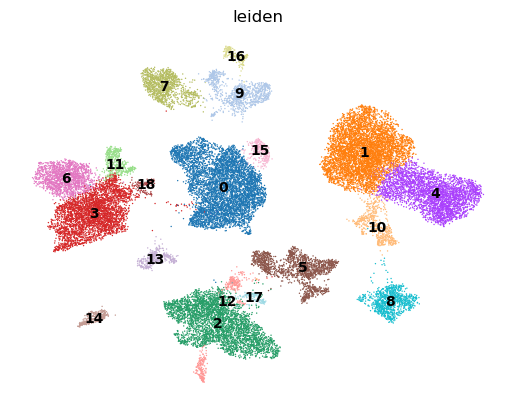

In [26]:
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc="on data")

Find Immune Cell Markers: Identifiers can be found at --> https://blog.cellsignal.com/more-than-a-pehnotype-a-guide-to-assessing-tumor-infiltrating-immmune-cell-types-and-functions

Cell type gene expression markers can be found at --> https://panglaodb.se/markers.html?cell_type=%27choose%27

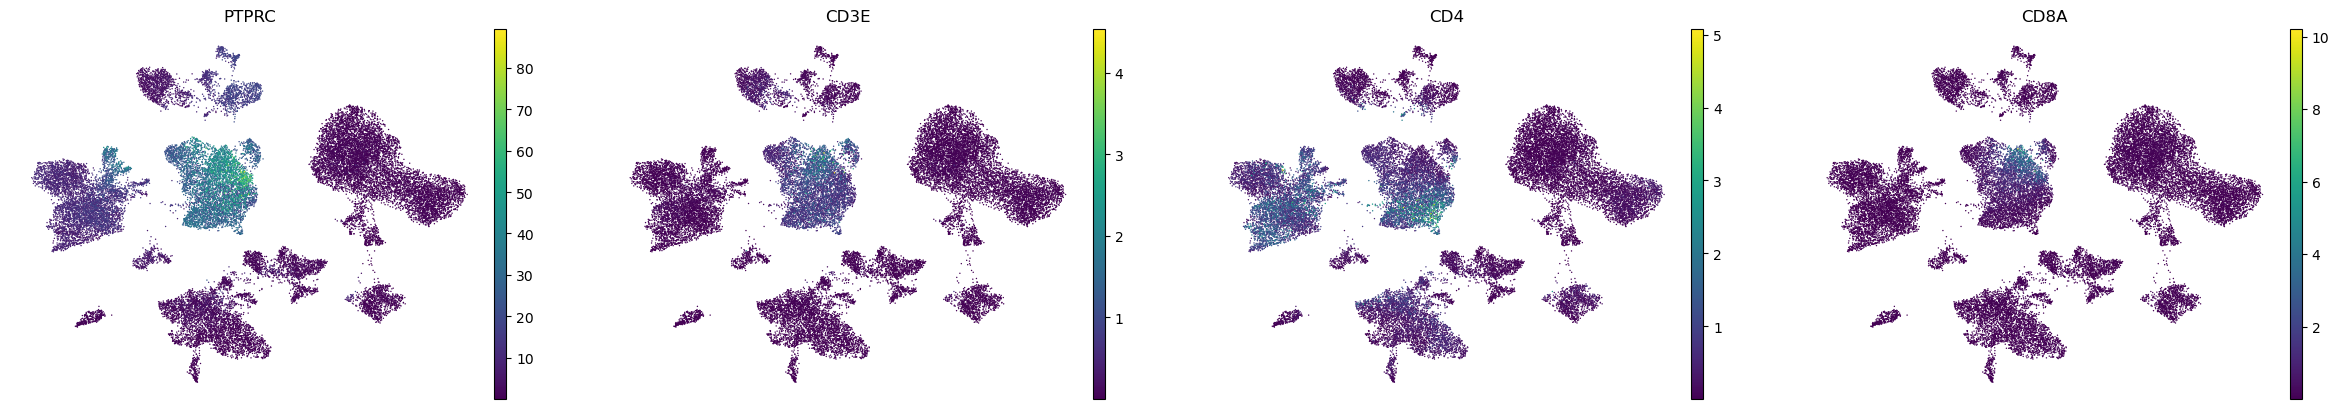

In [27]:
# find Immune Cell Markers
sc.pl.umap(adata, color = ['PTPRC', 'CD3E','CD4', 'CD8A'], frameon=False, layer='scvi_normalized')

If you look at CD4 and CD8A, they are sharing the same leiden region: 0 but the cell type regions look like the leiden region needs to split 0 in half for the two distinct cell types.

Increase the leiden resolution; rerun the marker gene program.

c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:440: PerformanceWarning: DataFrame is h

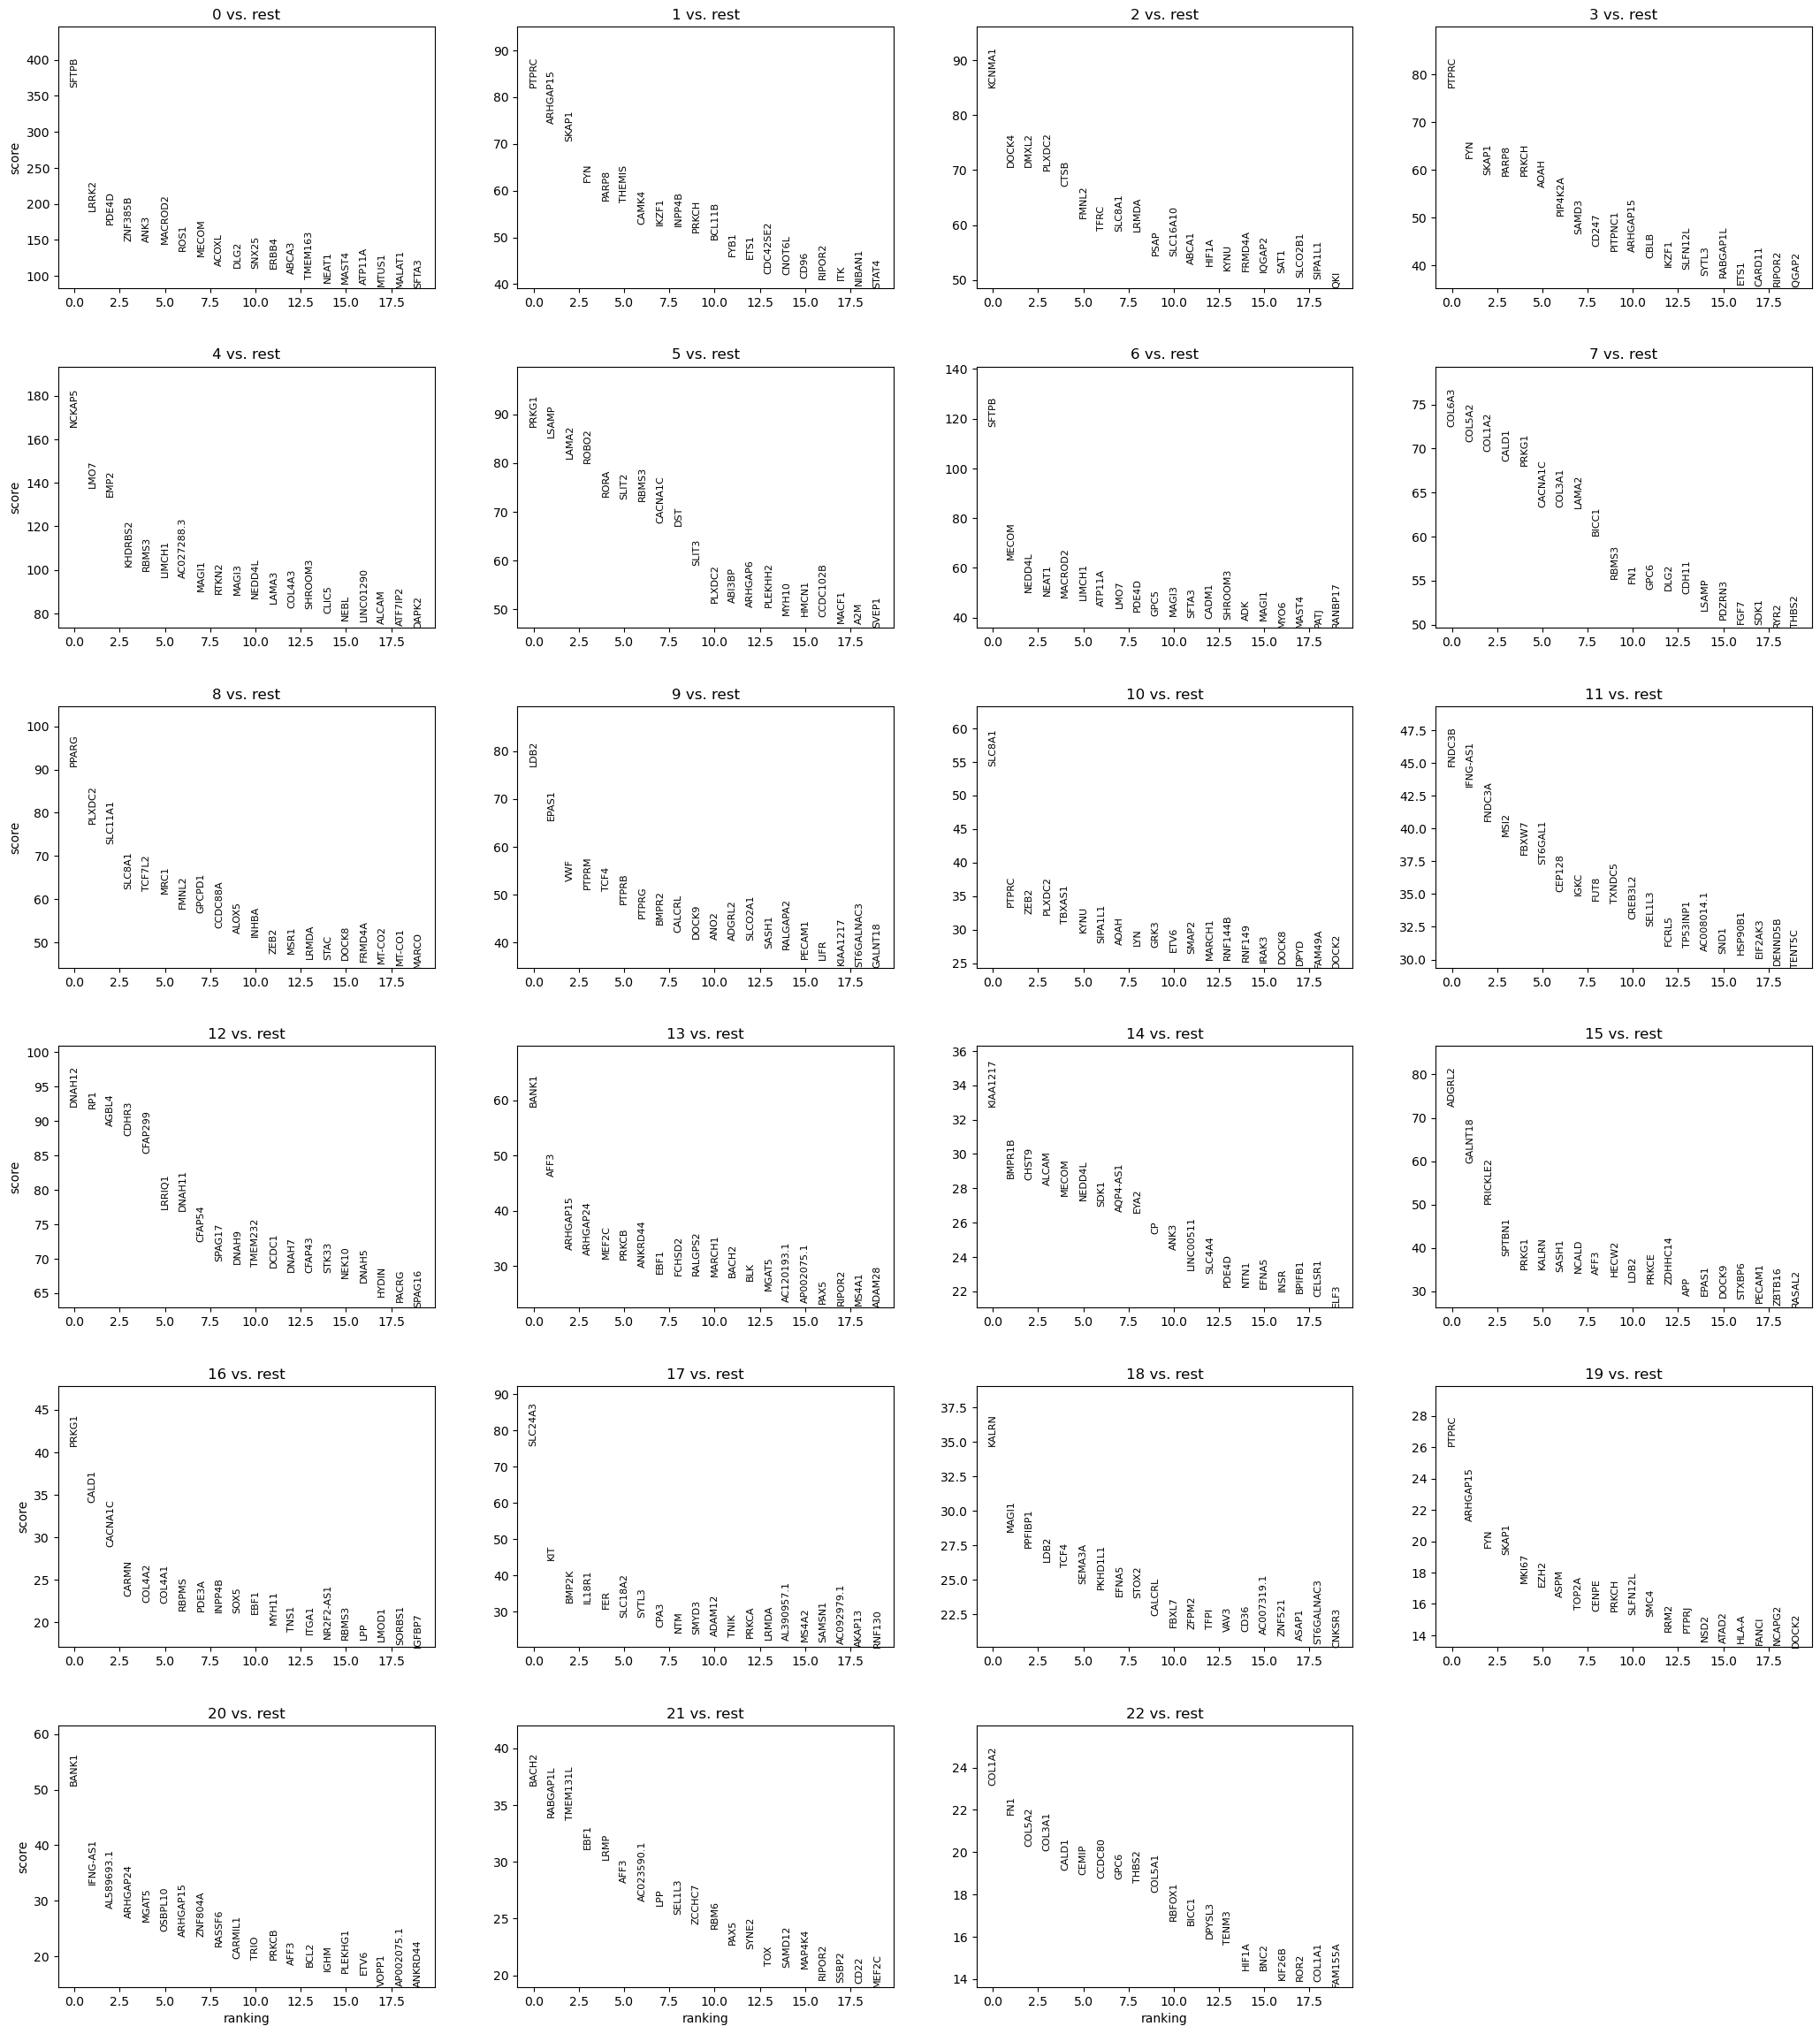

DE...: 100%|██████████| 23/23 [08:29<00:00, 22.14s/it]


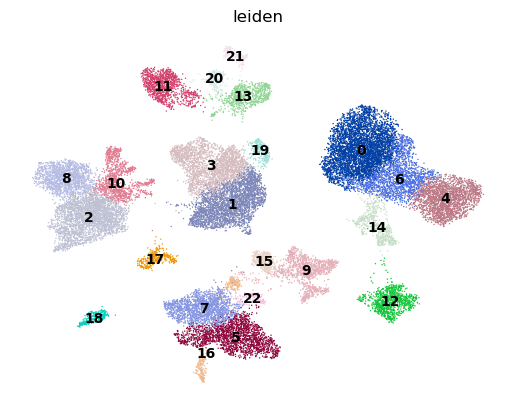

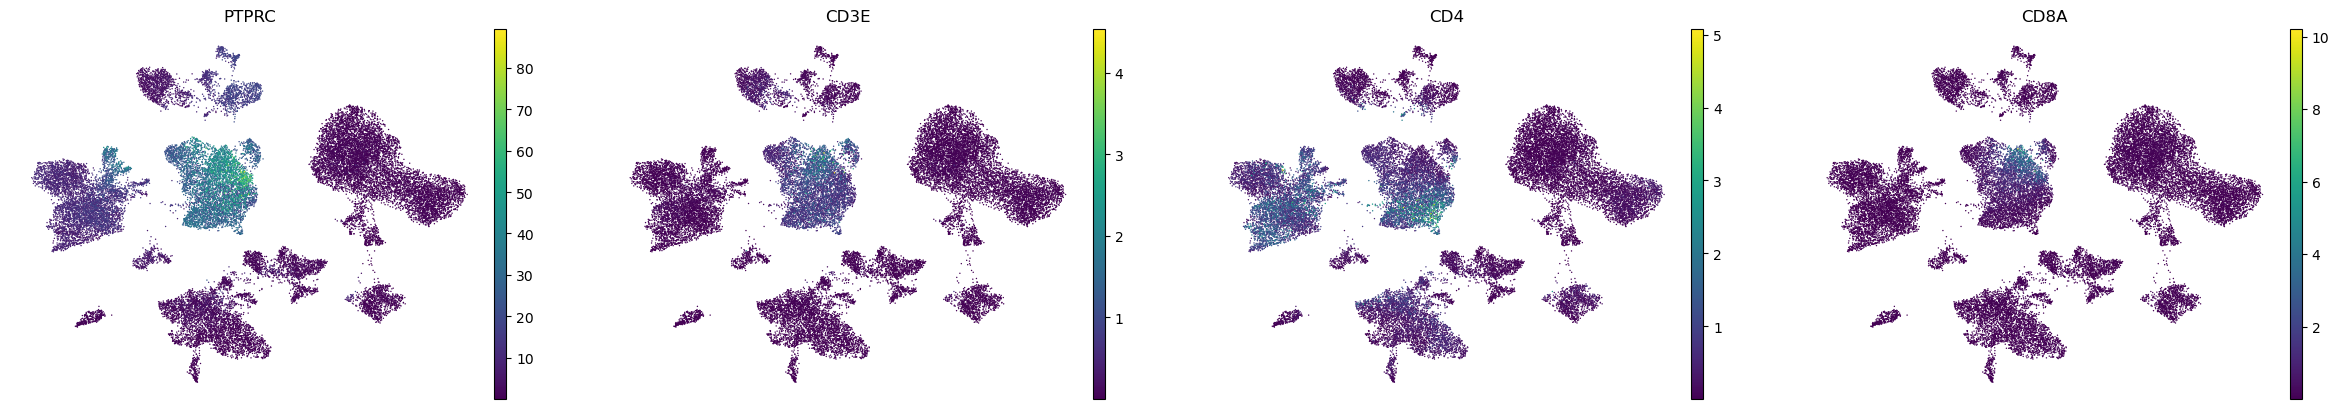

In [28]:
sc.tl.leiden(adata, resolution=1)

# Get the marker genes based on the leiden model and the raw data saved.
sc.tl.rank_genes_groups(adata, 'leiden')
#plot the top 20 marker genes.
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
# calling the differential expression from the model and grouping by leiden.
markers_scvi = model.differential_expression(groupby='leiden')
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > 0.5)]
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc="on data")
# find Immune Cell Markers
sc.pl.umap(adata, color = ['PTPRC', 'CD3E','CD4', 'CD8A'], frameon=False, layer='scvi_normalized')

The leiden marker identifiers are now appropriately separating the cell markers.

In [29]:
markers[markers.names == 'CD4']

group names     scores  logfoldchanges         pvals     pvals_adj
16915      1   CD4  10.721413        1.864691  2.322434e-26  7.969334e-26
33486      2   CD4  14.583337        2.430337  1.405502e-46  7.750260e-46
133870     8   CD4   6.879140        1.319941  8.564443e-12  2.463586e-11
165270    10   CD4   7.527126        1.836790  1.020392e-13  3.916773e-13

In [30]:
markers[markers.names == 'CD8A']

group names     scores  logfoldchanges         pvals     pvals_adj
17321      1  CD8A   6.598283        1.823877  4.865172e-11  1.156505e-10
49661      3  CD8A  13.257216        4.428377  1.033926e-38  4.177041e-38
313700    19  CD8A   4.061245        2.813394  6.286292e-05  1.458126e-04

We can confirm the groups for the two cell types are in different groups.

logfoldchanges is levels of expression in the specified group.

Lets make a dictionary to specify each group to cell type.

In [31]:
leiden_dict = {"3":"CD4+ T-cell",
               "4":"CD8+ T-cell",
               "5":"CD4+ T-cell",
 }

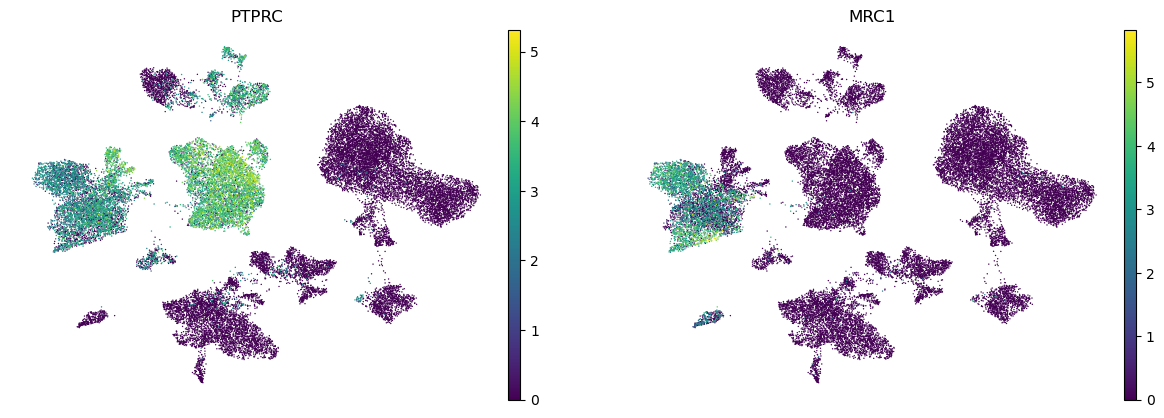

In [32]:
#We see MRC1 covering mutliple regions (3,6,8) however MRC1 is "Aveolar Macrophages" but can specify which type of Macrophage to look for to be more specific to one region.
sc.pl.umap(adata, color = ['PTPRC', 'MRC1'], frameon=False)

In [33]:
markers[markers.names == 'MRC1']

group names     scores  logfoldchanges         pvals     pvals_adj
32967      2  MRC1  46.748425        4.396149  0.000000e+00  0.000000e+00
131773     8  MRC1  61.327839        5.482769  0.000000e+00  0.000000e+00
165235    10  MRC1   7.773520        1.184088  1.619699e-14  6.359490e-14
296687    18  MRC1   8.356982        2.060781  2.521211e-15  1.118720e-14

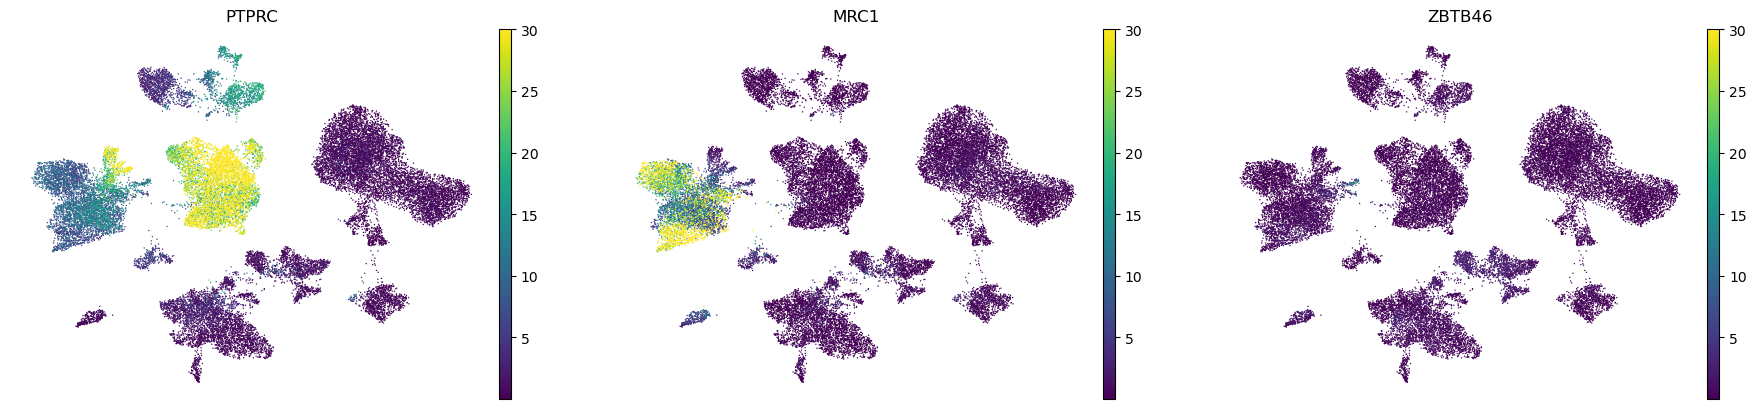

In [34]:
sc.pl.umap(adata, color = ['PTPRC','MRC1','ZBTB46'], frameon=False, layer='scvi_normalized', vmax=30)

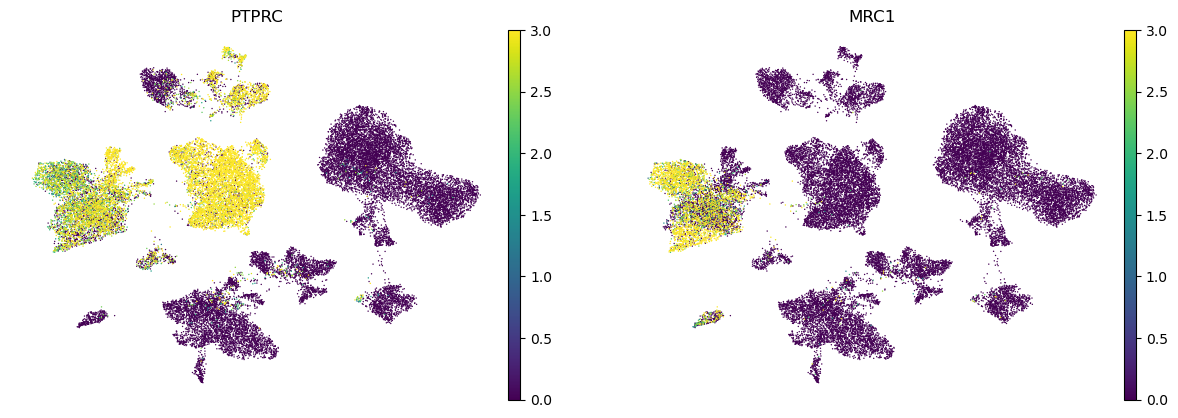

In [35]:
sc.pl.umap(adata, color = ['PTPRC', 'MRC1'], frameon=False, vmax=3)

In [36]:
markers[markers.names == 'APOBEC3A'] #monocyte @ 8

group     names    scores  logfoldchanges         pvals     pvals_adj
165150    10  APOBEC3A  8.675207        5.863703  1.372125e-17  5.790488e-17

Update the dictionary

In [37]:
leiden_dict = {"3":"CD4+ T-cell",
               "4":"CD8+ T-cell",
               "5":"CD4+ T-cell",
               "8":"Macrophage"}

In [38]:
# B-cell marker PXK
markers[markers.names == 'PXK']

group names     scores  logfoldchanges         pvals     pvals_adj
34297      2   PXK   7.579497        0.822341  4.507649e-14  1.248243e-13
83676      5   PXK   6.426807        0.805431  1.607679e-10  4.632624e-10
116122     7   PXK   9.789296        1.252365  4.266873e-22  2.018950e-21
165811    10   PXK   4.856317        0.812586  1.351370e-06  3.763681e-06
214305    13   PXK   9.292149        1.998564  1.640512e-19  5.404173e-19
346006    21   PXK  10.711699        3.422261  2.190141e-21  6.302202e-21
362744    22   PXK   4.832212        1.826247  3.174311e-06  1.177834e-05

Now that I understand how to search through immune cell gene expression markers, I will make a dictionary and iterate through it to look at cell expressions in each leiden region.

In [39]:
immune_cell_markers = {"B-cell":"PXK",
                       "Memory B-cell":"NPIPB15",
                       "Naive B-cell":"P2RX5",
                       "Basophil":"CCL4",
                       "Dendritic cell":"ITGAX",
                       "Eosinophils":"SIGLEC8",
                       "gdT-cell":"S100B",
                       "Macrophage":"CD68",
                       "Mast cell":"KIT",
                       "Megakaryocyte":"CIB1",
                       "Monocyte":"APOBEC3A",
                       "NKT-cell":"NCAM1",
                       "Neutrophils":"CSF3R",
                       "NK cell":"NKG7",
                       "T-cell":"TRBC2",
                       "T cytotoxic cell":"TRAC",
                       "T memory cell":"CCR7"}

other_cell_markers = {"Endothelial cell":"CD93",
                      "Endothelial cell_2_":"PECAM1",
                      "Fibroblast cell":"COL6A2",
                      "AT1":"AGER",
                      "AT2":"SFTPC",
                      "Pericyte":"PDGFRB"}

In [40]:
for cell in other_cell_markers:
    gene = other_cell_markers[cell]
    print(f'{cell}: {gene}')

Endothelial cell: CD93
Endothelial cell_2_: PECAM1
Fibroblast cell: COL6A2
AT1: AGER
AT2: SFTPC
Pericyte: PDGFRB


The for loop below will iterate through each cell expression and if the logfoldchange values are high enough, then append to leiden dictionary.

In [56]:
for cell in other_cell_markers:
    gene = other_cell_markers[cell]
    print(f'{cell}: {gene}')
    display(markers[markers.names == gene])
    ans = input("Continue? [y/n]")
    if ans == "y":
        continue
    else:
        while ans != "y":
            ans = input("Please type 'y' to continue: ")

Endothelial cell: CD93


group names     scores  logfoldchanges         pvals     pvals_adj
34249      2  CD93   7.827209        1.777626  6.845114e-15  1.942890e-14
148413     9  CD93  16.632908        4.916028  2.139445e-56  2.509886e-55
165456    10  CD93   6.408304        2.101915  2.119694e-10  7.183843e-10

Endothelial cell_2_: PECAM1


group   names     scores  logfoldchanges          pvals      pvals_adj
33490      2  PECAM1  14.497599        1.274073   3.426783e-46   1.882045e-45
131997     8  PECAM1  22.143078        2.241252   3.859823e-95   4.114896e-94
148254     9  PECAM1  36.576927        4.288541  4.325493e-202  3.057734e-200
164854    10  PECAM1  14.358496        1.980682   2.913544e-43   2.166546e-42
181899    11  PECAM1   5.892517        0.870906   4.964762e-09   1.289617e-08
247082    15  PECAM1  27.220444        4.850302   6.163742e-92   6.850404e-91
296680    18  PECAM1   8.526489        2.102587   7.884708e-16   3.523305e-15

Fibroblast cell: COL6A2


group   names     scores  logfoldchanges          pvals      pvals_adj
82553      5  COL6A2  22.658875        3.436956  3.866876e-101  5.087166e-100
115401     7  COL6A2  29.789242        4.493798  5.076802e-158  1.509386e-156
263634    16  COL6A2  10.334570        3.286040   5.053405e-22   2.730795e-21
362603    22  COL6A2   5.983924        2.833455   1.418187e-08   5.743534e-08

AT1: AGER


group names     scores  logfoldchanges          pvals      pvals_adj
66029      4  AGER  34.308517        6.689876  2.588027e-205  6.080939e-204
100230     6  AGER   6.152090        1.188914   9.356240e-10   3.700039e-09

AT2: SFTPC


group  names     scores  logfoldchanges         pvals     pvals_adj
50        0  SFTPC  61.671589        5.992624  0.000000e+00  0.000000e+00
99061     6  SFTPC  16.360439        2.356390  3.465680e-56  4.480629e-55

Pericyte: PDGFRB


group   names     scores  logfoldchanges         pvals     pvals_adj
82958      5  PDGFRB  11.926710        2.659626  1.033002e-31  5.477969e-31
115701     7  PDGFRB  15.775416        3.494105  1.576648e-52  1.464691e-51
263584    16  PDGFRB  13.024483        5.404861  7.228698e-32  5.469172e-31
363214    22  PDGFRB   3.223000        2.201740  1.541951e-03  4.595996e-03

In [42]:
leiden_dict = {"0":"AT2",
               "1":"AT1",
               "2":"Fibroblast Cell",
               "3":"CD4+ T-cell",
               "4":"CD8+ T-cell",
               "5":"CD4+ T-cell",
               "7":"Endothelial cell",
               "8":"Macrophage"}

In [57]:
for cell in immune_cell_markers:
    gene = immune_cell_markers[cell]
    print(f'{cell}: {gene}')
    display(markers[markers.names == gene])
    ans = input("Continue? [y/n]")
    if ans == "y":
        continue
    else:
        while ans != "y":
            ans = input("Please type 'y' to continue: ")

B-cell: PXK


group names     scores  logfoldchanges         pvals     pvals_adj
34297      2   PXK   7.579497        0.822341  4.507649e-14  1.248243e-13
83676      5   PXK   6.426807        0.805431  1.607679e-10  4.632624e-10
116122     7   PXK   9.789296        1.252365  4.266873e-22  2.018950e-21
165811    10   PXK   4.856317        0.812586  1.351370e-06  3.763681e-06
214305    13   PXK   9.292149        1.998564  1.640512e-19  5.404173e-19
346006    21   PXK  10.711699        3.422261  2.190141e-21  6.302202e-21
362744    22   PXK   4.832212        1.826247  3.174311e-06  1.177834e-05

Memory B-cell: NPIPB15


group    names    scores  logfoldchanges     pvals  pvals_adj
2936       0  NPIPB15  4.834666        0.861627  0.000001   0.000003
69771      4  NPIPB15  2.635985        0.632014  0.008445   0.013739
102159     6  NPIPB15  2.840220        0.750534  0.004557   0.009595
201592    12  NPIPB15  2.943381        0.987929  0.003321   0.005755
231845    14  NPIPB15  4.241177        1.924986  0.000026   0.000105

Naive B-cell: P2RX5


group  names     scores  logfoldchanges         pvals     pvals_adj
18255      1  P2RX5   3.088110        0.789781  2.031000e-03  3.276455e-03
51144      3  P2RX5   2.490688        0.723604  1.281366e-02  1.919719e-02
182289    11  P2RX5   4.419630        1.677243  1.082300e-05  2.358324e-05
214332    13  P2RX5   8.614631        3.786010  4.259700e-17  1.363684e-16
314375    19  P2RX5   2.700777        1.903214  7.323518e-03  1.436704e-02
329729    20  P2RX5   3.755328        2.968676  2.203698e-04  4.164422e-04
346003    21  P2RX5  10.803652        5.939035  1.199801e-21  3.456091e-21

Basophil: CCL4


group names     scores  logfoldchanges         pvals     pvals_adj
18011      1  CCL4   3.696635        0.976956  2.220500e-04  3.857188e-04
49681      3  CCL4  12.664212        3.992400  1.383429e-35  5.331413e-35
136943     8  CCL4   2.937546        0.885566  3.353781e-03  5.413576e-03
314497    19  CCL4   2.519029        1.899981  1.230440e-02  2.349203e-02

Dendritic cell: ITGAX


group  names     scores  logfoldchanges          pvals      pvals_adj
33015      2  ITGAX  34.448875        3.895485  1.606846e-218  3.188718e-217
131995     8  ITGAX  22.171284        2.891374   5.089095e-95   5.414890e-94
164787    10  ITGAX  17.480522        2.851990   4.868366e-61   4.741979e-60
280627    17  ITGAX   3.485487        1.116905   5.578657e-04   1.420406e-03

Eosinophils: SIGLEC8


Empty DataFrame
Columns: [group, names, scores, logfoldchanges, pvals, pvals_adj]
Index: []

gdT-cell: S100B


Empty DataFrame
Columns: [group, names, scores, logfoldchanges, pvals, pvals_adj]
Index: []

Macrophage: CD68


group names     scores  logfoldchanges         pvals     pvals_adj
33493      2  CD68  14.456103        2.867047  8.389535e-46  4.590832e-45
132075     8  CD68  19.732796        4.523876  1.958693e-77  1.773592e-76
166588    10  CD68   2.964732        0.857291  3.088608e-03  6.198667e-03

Mast cell: KIT


group names     scores  logfoldchanges          pvals      pvals_adj
280008    17   KIT  44.173859       11.491651  1.938638e-139  5.004908e-138

Megakaryocyte: CIB1


group names     scores  logfoldchanges         pvals     pvals_adj
134319     8  CIB1   5.860867        1.686229  5.591297e-09  1.426270e-08
198754    12  CIB1  10.767609        3.370842  1.258488e-25  5.947936e-25
231688    14  CIB1   4.586358        2.130516  5.542169e-06  2.422640e-05

Monocyte: APOBEC3A


group     names    scores  logfoldchanges         pvals     pvals_adj
165150    10  APOBEC3A  8.675207        5.863703  1.372125e-17  5.790488e-17

NKT-cell: NCAM1


group  names     scores  logfoldchanges         pvals     pvals_adj
49637      3  NCAM1  14.024438        4.165411  6.096833e-43  2.606305e-42
84444      5  NCAM1   3.816134        1.028290  1.395015e-04  2.752430e-04
264528    16  NCAM1   2.771877        1.759078  5.870717e-03  1.490391e-02
314521    19  NCAM1   2.489874        1.762766  1.333731e-02  2.532612e-02

Neutrophils: CSF3R


group  names     scores  logfoldchanges         pvals     pvals_adj
87         0  CSF3R  53.977837        4.206178  0.000000e+00  0.000000e+00
34500      2  CSF3R   6.538292        0.624068  7.193039e-11  1.792655e-10
100511     6  CSF3R   5.336739        0.613554  1.059714e-07  3.689399e-07
165128    10  CSF3R   8.906857        1.349633  1.901354e-18  8.183223e-18

NK cell: NKG7


group names     scores  logfoldchanges         pvals     pvals_adj
49589      3  NKG7  16.106974        5.801260  2.225521e-55  1.096845e-54
313644    19  NKG7   4.230931        2.983779  3.125205e-05  7.353607e-05

T-cell: TRBC2


group  names    scores  logfoldchanges         pvals     pvals_adj
16974      1  TRBC2  9.835505        3.379394  1.726173e-22  5.422810e-22
49977      3  TRBC2  7.891457        2.972021  4.551784e-15  1.197069e-14
313991    19  TRBC2  3.372053        2.886949  8.474803e-04  1.823494e-03

T cytotoxic cell: TRAC


group names     scores  logfoldchanges         pvals     pvals_adj
16816      1  TRAC  12.375660        3.348729  2.401552e-34  9.524674e-34
49828      3  TRAC   9.577393        2.810702  2.434184e-21  7.139147e-21
313278    19  TRAC   6.101431        3.710671  3.361364e-09  8.916898e-09

T memory cell: CCR7


group names    scores  logfoldchanges         pvals     pvals_adj
17181      1  CCR7  7.652016        2.548421  2.640092e-14  6.935398e-14
200958    12  CCR7  3.766567        1.630978  1.751772e-04  3.503332e-04
214532    13  CCR7  5.978899        3.250476  3.501239e-09  9.627530e-09
329661    20  CCR7  4.276756        3.873214  2.802610e-05  5.417414e-05

In [44]:
leiden_dict = {"0":"AT2",
               "1":"AT1",
               "2":"Fibroblast Cell",
               "3":"CD4+ T-cell",
               "4":"CD8+ T-cell",
               "5":"CD4+ T-cell",
               "6":"Macrophage",
               "7":"Endothelial cell",
               "8":"Macrophage",
               "9":"",
               "10":"Megakaryocyte",
               "11":"Memory T-cell",
               "12":"",
               "13":"Natural Killer T-cell",
               "14":"",
               "15":"",
               "16":"",
               "17":"Pericytes",
               "18":"Mast cell",
               "19":"",
               "20":""
               "21":"Naive B-cell",
               "22":""
               }

SyntaxError: invalid syntax (4082613427.py, line 22)

It can be a bit tough to identify the rest of the leiden markers. So we will do a reverse search. Only use this as a second resort as it may be less accurate.

In [89]:
# lets try to fill in leiden region 22
markers_scvi[markers_scvi.group1 == '18']

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
PROX1         1.0000        0.0000     18.420681  0.000862  0.000005   
MMRN1         0.9998        0.0002      8.516943  0.001275  0.000007   
RELN          0.9998        0.0002      8.516943  0.001296  0.000003   
TBX1          0.9996        0.0004      7.823621  0.000642  0.000010   
SEMA3A        0.9996        0.0004      7.823621  0.002122  0.000035   
...              ...           ...           ...       ...       ...   
TINCR         0.9250        0.0750      2.512306  0.000010  0.000006   
ARHGAP18      0.9250        0.0750      2.512306  0.000334  0.000317   
POLR3G        0.9248        0.0752      2.509426  0.000025  0.000008   
UBE2M         0.9248        0.0752      2.509426  0.000004  0.000005   
AC006059.1    0.9248        0.0752      2.509426  0.000079  0.000041   

            pseudocounts  delta   lfc_mean  lfc_median   lfc_std  ...  \
PROX1                0.0   0.25   9.744848    9.177946  3.580101  ...   
MMRN1                0.0   0.25  10.509673   10.403463  3.294212  ...   
RELN                 0.0   0.25  13.252876   12.946567  4.711230  ...   
TBX1                 0.0   0.25   8.137781    7.817719  3.268132  ...   
SEMA3A               0.0   0.25   9.524009    8.063488  5.441739  ...   
...                  ...    ...        ...         ...       ...  ...   
TINCR                0.0   0.25   0.617904    0.525976  2.399870  ...   
ARHGAP18             0.0   0.25   0.960158    1.112308  1.826799  ...   
POLR3G               0.0   0.25   1.871869    1.737502  1.843586  ...   
UBE2M                0.0   0.25   0.542508    0.387458  2.578600  ...   
AC006059.1           0.0   0.25   0.898144    0.855214  2.515191  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
PROX1        0.996598   0.002510               0.421769   
MMRN1        1.904761   0.003713               0.588435   
RELN         1.867346   0.001341               0.612245   
TBX1         0.687075   0.009146               0.411565   
SEMA3A       2.955781   0.033179               0.717687   
...               ...        ...                    ...   
TINCR        0.006803   0.005192               0.006803   
ARHGAP18     0.404762   0.345647               0.261905   
POLR3G       0.013605   0.007495               0.013605   
UBE2M        0.003401   0.005020               0.003401   
AC006059.1   0.142857   0.072443               0.115646   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
PROX1                    0.002338              7.668537              0.021802   
MMRN1                    0.002063             14.107956              0.030468   
RELN                     0.000756             14.588673              0.008428   
TBX1                     0.008595              5.505394              0.061081   
SEMA3A                   0.024171             21.332235              0.211328   
...                           ...                   ...                   ...   
TINCR                    0.005089              0.045687              0.040085   
ARHGAP18                 0.177342              2.630252              2.571521   
POLR3G                   0.007151              0.076105              0.050341   
UBE2M                    0.004985              0.022540              0.039564   
AC006059.1               0.064432              0.985304              0.515786   

            is_de_fdr_0.05  comparison  group1 group2  
PROX1                 True  18 vs Rest      18   Rest  
MMRN1                 True  18 vs Rest      18   Rest  
RELN                  True  18 vs Rest      18   Rest  
TBX1                  True  18 vs Rest      18   Rest  
SEMA3A                True  18 vs Rest      18   Rest  
...                    ...         ...     ...    ...  
TINCR                 True  18 vs Rest      18   Rest  
ARHGAP18              True  18 vs Rest      18   Rest  
POLR3G                True  18 vs Rest      18   Rest  
UBE2M                 True  

For Region 12, I am getting an overwhelming amount of gene markers pointing to Neuronal Cells, not enough support to justify it is Fibroblasts or Pericytes. I am currently researching papers for this possibility. 

To confirm Neuronal gene marker, I will test canonical Neuronal markers such as 'NEUROD1', 'SYP', and 'RBFOX3' for confirmation of neuronal identity. Update, no match, confirm not neuronal cells.

Paper(s): https://aacrjournals.org/cancerres/article/84/9/1410/745079/Single-Cell-Analysis-Identifies-NOTCH3-Mediated, https://molecularneurodegeneration.biomedcentral.com/articles/10.1186/1750-1326-5-32, https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2022.988246/full, confirm the use of PDGFRB, NOTCH3, and ACTA2 all were co-expressed in region 12. No other regions were presented in all 3 gene markers. This suggests incredibly strong support Region 12 are Pericytes.

In [97]:
markers[markers.names == 'CYP4B1']

group   names     scores  logfoldchanges          pvals      pvals_adj
66008      4  CYP4B1  37.439754        4.154912  1.411981e-236  3.806340e-235
99054      6  CYP4B1  16.537550        2.130492   2.663707e-57   3.524010e-56
198239    12  CYP4B1  15.636302        2.497280   2.073374e-49   1.641853e-48
231216    14  CYP4B1   6.521560        1.446991   1.518444e-10   9.012716e-10

Then look up the Gene marker to find the cell at --> https://panglaodb.se/search.html

From the top 4 gene identifications for region 22, the first two gene markers presented "Neuronal cells" then the second two gene markers presented "Fibroblasts".

Two reasons its Fibroblasts: 1. The leiden umap shows leiden region 22 close to 17 (Pericytes) and 2 (Fibroblasts).  2. I hope you dont have neuronal cells in your lungs....

In [98]:
leiden_dict = {"0":"AT2",
               "1":"T-Cell",
               "2":"Dendritic-Cell",
               "3":"NK-Cell",
               "4":"AT1",
               "5":"Fibroblast",
               "6":"Pulmonary Alveolar Type-II Cell",
               "7":"Fibroblast",
               "8":"Macrophage",
               "9":"Endothelial-Cell",
               "10":"Monocyte",
               "11":"Plasma-Cell",
               "12":"Epithelial Cell",
               "13":"B-Cell",
               "14":"Luminal Epithelial Cell",
               "15":"Endothelial-Cell",
               "16":"Pericyte",
               "17":"Mast-Cell",
               "18":"Hemangioblasts",
               "19":"T-Cell",
               "20":"Memory T-Cell",
               "21":"Naive B-Cell",
               "22":"Fibroblast"}

In [99]:
adata.obs

Sample  doublet  n_genes  n_genes_by_counts  \
CGTTCTGGTACTAGCT-1_1   mini/GSM5226574    False     2434               2434   
CTGGCAGGTTCGGTAT-1_1   mini/GSM5226574    False     2444               2444   
ACACCAACACAACGCC-1_1   mini/GSM5226574    False     2451               2451   
CCTCAACCATACAGGG-1_1   mini/GSM5226574    False     2276               2276   
ACAAAGATCCACAGGC-1_1   mini/GSM5226574    False     2310               2310   
...                                ...      ...      ...                ...   
CCTAAGAAGTTGTCAC-1_27  mini/GSM5226600    False      344                344   
CGTGAATCATGTCTAG-1_27  mini/GSM5226600    False      350                350   
GCCGATGAGTAAACGT-1_27  mini/GSM5226600    False      326                326   
AGGGTGAGTATCAGGG-1_27  mini/GSM5226600    False      331                331   
ATGGATCAGAGAGCAA-1_27  mini/GSM5226600    False      335                335   

                       total_counts  total_counts_mt  pct_counts_mt  \
CGTTCTGGTACTAGCT-1_1         6047.0              0.0            0.0   
CTGGCAGGTTCGGTAT-1_1         5899.0              0.0            0.0   
ACACCAACACAACGCC-1_1         5497.0              0.0            0.0   
CCTCAACCATACAGGG-1_1         5434.0              0.0            0.0   
ACAAAGATCCACAGGC-1_1         5504.0              0.0            0.0   
...                             ...              ...            ...   
CCTAAGAAGTTGTCAC-1_27         413.0              0.0            0.0   
CGTGAATCATGTCTAG-1_27         402.0              0.0            0.0   
GCCGATGAGTAAACGT-1_27         401.0              0.0            0.0   
AGGGTGAGTATCAGGG-1_27         402.0              0.0            0.0   
ATGGATCAGAGAGCAA-1_27         403.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
CGTTCTGGTACTAGCT-1_1                 1.0         0.016537            0   
CTGGCAGGTTCGGTAT-1_1                 5.0         0.084760            0   
ACACCAACACAACGCC-1_1                 3.0         0.054575            0   
CCTCAACCATACAGGG-1_1                 0.0         0.000000            0   
ACAAAGATCCACAGGC-1_1                 1.0         0.018169            0   
...                                  ...              ...          ...   
CCTAAGAAGTTGTCAC-1_27                0.0         0.000000            0   
CGTGAATCATGTCTAG-1_27                0.0         0.000000            0   
GCCGATGAGTAAACGT-1_27                8.0         1.995013            0   
AGGGTGAGTATCAGGG-1_27                0.0         0.000000            0   
ATGGATCAGAGAGCAA-1_27                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling  \
CGTTCTGGTACTAGCT-1_1              0      0                1.661129   
CTGGCAGGTTCGGTAT-1_1              0      0                1.705902   
ACACCAACACAACGCC-1_1              0      4                1.827151   
CCTCAACCATACAGGG-1_1              0      8                1.847746   
ACAAAGATCCACAGGC-1_1              0      0                1.827485   
...                             ...    ...                     ...   
CCTAAGAAGTTGTCAC-1_27             0      7               24.213076   
CGTGAATCATGTCTAG-1_27             0      2               24.937656   
GCCGATGAGTAAACGT-1_27             0      0               25.316456   
AGGGTGAGTATCAGGG-1_27             0      6               25.062656   
ATGGATCAGAGAGCAA-1_27             0      2               24.937656   

                              Cell_Type  
CGTTCTGGTACTAGCT-1_1                AT2  
CTGGCAGGTTCGGTAT-1_1                AT2  
ACACCAACACAACGCC-1_1        CD8+ T-cell  
CCTCAACCATACAGGG-1_1         Macrophage  
ACAAAGATCCACAGGC-1_1                AT2  
...                                 ...  
CCTAAGAAGTTGTCAC-1_27  Endothelial cell  
CGTGAATCATGTCTAG-1_27        Fibroblast  
GCCGATGAGTAAACGT-1_27               AT2  
AGGGTGAGTATCAGGG-1_27        Macrophage  
ATGGATCAGAGAGCAA-1_27        Fibroblas

Do you spot the 'leiden' column. Map it to the dictionary we just made.

In [100]:
adata.obs['Cell_Type'] = adata.obs.leiden.map(leiden_dict)

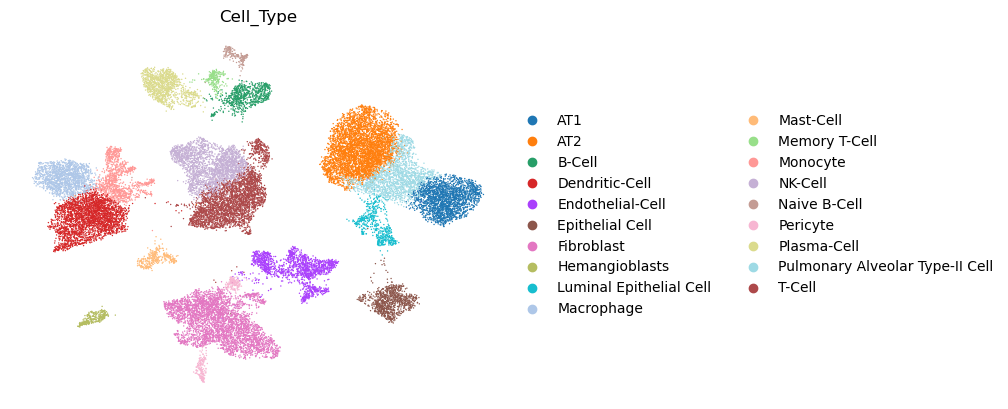

In [101]:
sc.pl.umap(adata, color=['Cell_Type'], frameon=False)

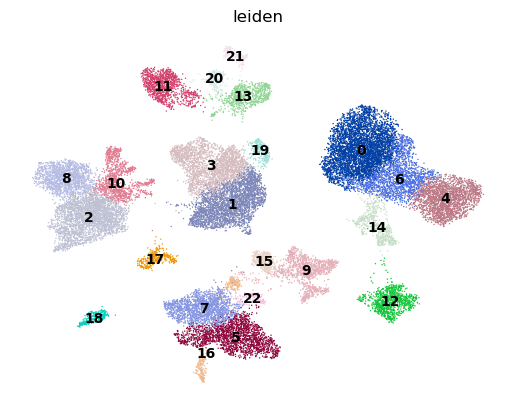

In [102]:
sc.pl.umap(adata, color = ['leiden'], frameon=False, legend_loc='on data')

In [52]:
adata.obs

Sample  doublet  n_genes  n_genes_by_counts  \
CGTTCTGGTACTAGCT-1_1   mini/GSM5226574    False     2434               2434   
CTGGCAGGTTCGGTAT-1_1   mini/GSM5226574    False     2444               2444   
ACACCAACACAACGCC-1_1   mini/GSM5226574    False     2451               2451   
CCTCAACCATACAGGG-1_1   mini/GSM5226574    False     2276               2276   
ACAAAGATCCACAGGC-1_1   mini/GSM5226574    False     2310               2310   
...                                ...      ...      ...                ...   
CCTAAGAAGTTGTCAC-1_27  mini/GSM5226600    False      344                344   
CGTGAATCATGTCTAG-1_27  mini/GSM5226600    False      350                350   
GCCGATGAGTAAACGT-1_27  mini/GSM5226600    False      326                326   
AGGGTGAGTATCAGGG-1_27  mini/GSM5226600    False      331                331   
ATGGATCAGAGAGCAA-1_27  mini/GSM5226600    False      335                335   

                       total_counts  total_counts_mt  pct_counts_mt  \
CGTTCTGGTACTAGCT-1_1         6047.0              0.0            0.0   
CTGGCAGGTTCGGTAT-1_1         5899.0              0.0            0.0   
ACACCAACACAACGCC-1_1         5497.0              0.0            0.0   
CCTCAACCATACAGGG-1_1         5434.0              0.0            0.0   
ACAAAGATCCACAGGC-1_1         5504.0              0.0            0.0   
...                             ...              ...            ...   
CCTAAGAAGTTGTCAC-1_27         413.0              0.0            0.0   
CGTGAATCATGTCTAG-1_27         402.0              0.0            0.0   
GCCGATGAGTAAACGT-1_27         401.0              0.0            0.0   
AGGGTGAGTATCAGGG-1_27         402.0              0.0            0.0   
ATGGATCAGAGAGCAA-1_27         403.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
CGTTCTGGTACTAGCT-1_1                 1.0         0.016537            0   
CTGGCAGGTTCGGTAT-1_1                 5.0         0.084760            0   
ACACCAACACAACGCC-1_1                 3.0         0.054575            0   
CCTCAACCATACAGGG-1_1                 0.0         0.000000            0   
ACAAAGATCCACAGGC-1_1                 1.0         0.018169            0   
...                                  ...              ...          ...   
CCTAAGAAGTTGTCAC-1_27                0.0         0.000000            0   
CGTGAATCATGTCTAG-1_27                0.0         0.000000            0   
GCCGATGAGTAAACGT-1_27                8.0         1.995013            0   
AGGGTGAGTATCAGGG-1_27                0.0         0.000000            0   
ATGGATCAGAGAGCAA-1_27                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling  \
CGTTCTGGTACTAGCT-1_1              0      0                1.661129   
CTGGCAGGTTCGGTAT-1_1              0      0                1.705902   
ACACCAACACAACGCC-1_1              0      4                1.827151   
CCTCAACCATACAGGG-1_1              0      8                1.847746   
ACAAAGATCCACAGGC-1_1              0      0                1.827485   
...                             ...    ...                     ...   
CCTAAGAAGTTGTCAC-1_27             0      7               24.213076   
CGTGAATCATGTCTAG-1_27             0      2               24.937656   
GCCGATGAGTAAACGT-1_27             0      0               25.316456   
AGGGTGAGTATCAGGG-1_27             0      6               25.062656   
ATGGATCAGAGAGCAA-1_27             0      2               24.937656   

                              Cell_Type  
CGTTCTGGTACTAGCT-1_1                AT2  
CTGGCAGGTTCGGTAT-1_1                AT2  
ACACCAACACAACGCC-1_1        CD8+ T-cell  
CCTCAACCATACAGGG-1_1         Macrophage  
ACAAAGATCCACAGGC-1_1                AT2  
...                                 ...  
CCTAAGAAGTTGTCAC-1_27  Endothelial cell  
CGTGAATCATGTCTAG-1_27        Fibroblast  
GCCGATGAGTAAACGT-1_27               AT2  
AGGGTGAGTATCAGGG-1_27        Macrophage  
ATGGATCAGAGAGCAA-1_27        Fibroblas

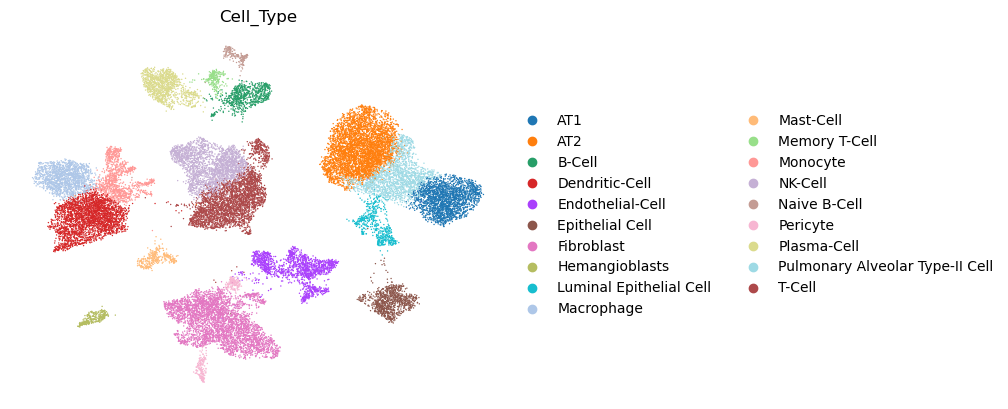

In [103]:
sc.pl.umap(adata, color=['Cell_Type'], frameon=False)

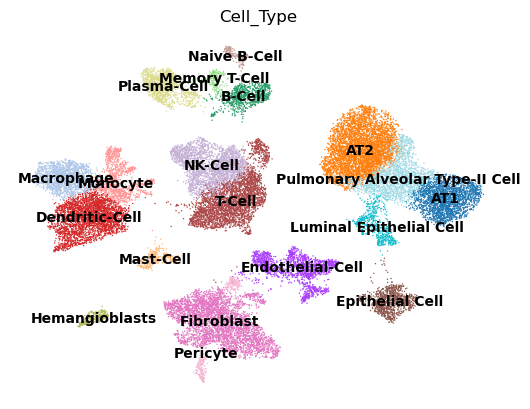

In [104]:
sc.pl.umap(adata, color=['Cell_Type'], frameon=False, legend_loc='on data')

In [105]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [106]:
adata.write_h5ad('integrated.h5ad')

In [107]:
model.save('model.model')

## Analysis

In [108]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

### Counting Cells

In [109]:
adata = sc.read_h5ad('integrated.h5ad')

In [110]:
adata.obs

Sample  doublet  n_genes  n_genes_by_counts  \
CGTTCTGGTACTAGCT-1_1   mini/GSM5226574    False     2434               2434   
CTGGCAGGTTCGGTAT-1_1   mini/GSM5226574    False     2444               2444   
ACACCAACACAACGCC-1_1   mini/GSM5226574    False     2451               2451   
CCTCAACCATACAGGG-1_1   mini/GSM5226574    False     2276               2276   
ACAAAGATCCACAGGC-1_1   mini/GSM5226574    False     2310               2310   
...                                ...      ...      ...                ...   
CCTAAGAAGTTGTCAC-1_27  mini/GSM5226600    False      344                344   
CGTGAATCATGTCTAG-1_27  mini/GSM5226600    False      350                350   
GCCGATGAGTAAACGT-1_27  mini/GSM5226600    False      326                326   
AGGGTGAGTATCAGGG-1_27  mini/GSM5226600    False      331                331   
ATGGATCAGAGAGCAA-1_27  mini/GSM5226600    False      335                335   

                       total_counts  total_counts_mt  pct_counts_mt  \
CGTTCTGGTACTAGCT-1_1         6047.0              0.0            0.0   
CTGGCAGGTTCGGTAT-1_1         5899.0              0.0            0.0   
ACACCAACACAACGCC-1_1         5497.0              0.0            0.0   
CCTCAACCATACAGGG-1_1         5434.0              0.0            0.0   
ACAAAGATCCACAGGC-1_1         5504.0              0.0            0.0   
...                             ...              ...            ...   
CCTAAGAAGTTGTCAC-1_27         413.0              0.0            0.0   
CGTGAATCATGTCTAG-1_27         402.0              0.0            0.0   
GCCGATGAGTAAACGT-1_27         401.0              0.0            0.0   
AGGGTGAGTATCAGGG-1_27         402.0              0.0            0.0   
ATGGATCAGAGAGCAA-1_27         403.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
CGTTCTGGTACTAGCT-1_1                 1.0         0.016537            0   
CTGGCAGGTTCGGTAT-1_1                 5.0         0.084760            0   
ACACCAACACAACGCC-1_1                 3.0         0.054575            0   
CCTCAACCATACAGGG-1_1                 0.0         0.000000            0   
ACAAAGATCCACAGGC-1_1                 1.0         0.018169            0   
...                                  ...              ...          ...   
CCTAAGAAGTTGTCAC-1_27                0.0         0.000000            0   
CGTGAATCATGTCTAG-1_27                0.0         0.000000            0   
GCCGATGAGTAAACGT-1_27                8.0         1.995013            0   
AGGGTGAGTATCAGGG-1_27                0.0         0.000000            0   
ATGGATCAGAGAGCAA-1_27                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling  \
CGTTCTGGTACTAGCT-1_1              0      0                1.661129   
CTGGCAGGTTCGGTAT-1_1              0      0                1.705902   
ACACCAACACAACGCC-1_1              0      4                1.827151   
CCTCAACCATACAGGG-1_1              0      8                1.847746   
ACAAAGATCCACAGGC-1_1              0      0                1.827485   
...                             ...    ...                     ...   
CCTAAGAAGTTGTCAC-1_27             0      7               24.213076   
CGTGAATCATGTCTAG-1_27             0      2               24.937656   
GCCGATGAGTAAACGT-1_27             0      0               25.316456   
AGGGTGAGTATCAGGG-1_27             0      6               25.062656   
ATGGATCAGAGAGCAA-1_27             0      2               24.937656   

                                             Cell_Type  
CGTTCTGGTACTAGCT-1_1                               AT2  
CTGGCAGGTTCGGTAT-1_1                               AT2  
ACACCAACACAACGCC-1_1                               AT1  
CCTCAACCATACAGGG-1_1                        Macrophage  
ACAAAGATCCACAGGC-1_1                               AT2  
...                                                ...  
CCTAAGAAGTTGTCAC-1_27                       Fibroblast  
CGTGAATCATGTCTAG-1_27                   Dend

In [111]:
adata.obs.Sample.unique().tolist()

['mini/GSM5226574',
 'mini/GSM5226575',
 'mini/GSM5226576',
 'mini/GSM5226598',
 'mini/GSM5226599',
 'mini/GSM5226600']

In [112]:
groups_ = {"mini/GSM5226574":"control",
           "mini/GSM5226575":"control",
           "mini/GSM5226576":"control",
           "mini/GSM5226598":"COVID19",
           "mini/GSM5226599":"COVID19",
           "mini/GSM5226600":"COVID19"}

In [113]:
adata.obs['condition'] = adata.obs.Sample.map(groups_)
adata.obs

Sample  doublet  n_genes  n_genes_by_counts  \
CGTTCTGGTACTAGCT-1_1   mini/GSM5226574    False     2434               2434   
CTGGCAGGTTCGGTAT-1_1   mini/GSM5226574    False     2444               2444   
ACACCAACACAACGCC-1_1   mini/GSM5226574    False     2451               2451   
CCTCAACCATACAGGG-1_1   mini/GSM5226574    False     2276               2276   
ACAAAGATCCACAGGC-1_1   mini/GSM5226574    False     2310               2310   
...                                ...      ...      ...                ...   
CCTAAGAAGTTGTCAC-1_27  mini/GSM5226600    False      344                344   
CGTGAATCATGTCTAG-1_27  mini/GSM5226600    False      350                350   
GCCGATGAGTAAACGT-1_27  mini/GSM5226600    False      326                326   
AGGGTGAGTATCAGGG-1_27  mini/GSM5226600    False      331                331   
ATGGATCAGAGAGCAA-1_27  mini/GSM5226600    False      335                335   

                       total_counts  total_counts_mt  pct_counts_mt  \
CGTTCTGGTACTAGCT-1_1         6047.0              0.0            0.0   
CTGGCAGGTTCGGTAT-1_1         5899.0              0.0            0.0   
ACACCAACACAACGCC-1_1         5497.0              0.0            0.0   
CCTCAACCATACAGGG-1_1         5434.0              0.0            0.0   
ACAAAGATCCACAGGC-1_1         5504.0              0.0            0.0   
...                             ...              ...            ...   
CCTAAGAAGTTGTCAC-1_27         413.0              0.0            0.0   
CGTGAATCATGTCTAG-1_27         402.0              0.0            0.0   
GCCGATGAGTAAACGT-1_27         401.0              0.0            0.0   
AGGGTGAGTATCAGGG-1_27         402.0              0.0            0.0   
ATGGATCAGAGAGCAA-1_27         403.0              0.0            0.0   

                       total_counts_ribo  pct_counts_ribo  _scvi_batch  \
CGTTCTGGTACTAGCT-1_1                 1.0         0.016537            0   
CTGGCAGGTTCGGTAT-1_1                 5.0         0.084760            0   
ACACCAACACAACGCC-1_1                 3.0         0.054575            0   
CCTCAACCATACAGGG-1_1                 0.0         0.000000            0   
ACAAAGATCCACAGGC-1_1                 1.0         0.018169            0   
...                                  ...              ...          ...   
CCTAAGAAGTTGTCAC-1_27                0.0         0.000000            0   
CGTGAATCATGTCTAG-1_27                0.0         0.000000            0   
GCCGATGAGTAAACGT-1_27                8.0         1.995013            0   
AGGGTGAGTATCAGGG-1_27                0.0         0.000000            0   
ATGGATCAGAGAGCAA-1_27                0.0         0.000000            0   

                       _scvi_labels leiden  _scvi_raw_norm_scaling  \
CGTTCTGGTACTAGCT-1_1              0      0                1.661129   
CTGGCAGGTTCGGTAT-1_1              0      0                1.705902   
ACACCAACACAACGCC-1_1              0      4                1.827151   
CCTCAACCATACAGGG-1_1              0      8                1.847746   
ACAAAGATCCACAGGC-1_1              0      0                1.827485   
...                             ...    ...                     ...   
CCTAAGAAGTTGTCAC-1_27             0      7               24.213076   
CGTGAATCATGTCTAG-1_27             0      2               24.937656   
GCCGATGAGTAAACGT-1_27             0      0               25.316456   
AGGGTGAGTATCAGGG-1_27             0      6               25.062656   
ATGGATCAGAGAGCAA-1_27             0      2               24.937656   

                                             Cell_Type condition  
CGTTCTGGTACTAGCT-1_1                               AT2   control  
CTGGCAGGTTCGGTAT-1_1                               AT2   control  
ACACCAACACAACGCC-1_1                               AT1   control  
CCTCAACCATACAGGG-1_1                        Macrophage   control  
ACAAAGATCCACAGGC-1_1                               AT2   control  
...                                                ...       ...  
CCTAAGAAGTTGTCAC-1_27          

Match the frequency of cell type to the cells total in each sample.

In [114]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

C:\Users\agarc\AppData\Local\Temp\ipykernel_10308\2419454245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['Sample']).count()


{'mini/GSM5226574': 5960,
 'mini/GSM5226575': 4415,
 'mini/GSM5226576': 6928,
 'mini/GSM5226598': 2429,
 'mini/GSM5226599': 3257,
 'mini/GSM5226600': 6390}

In [115]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'Cell_Type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis=1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

C:\Users\agarc\AppData\Local\Temp\ipykernel_10308\1347767741.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'Cell_Type']).count()


Sample condition                        Cell_Type  doublet
0    mini/GSM5226574   control                              AT1      750
1    mini/GSM5226574   control                              AT2      736
2    mini/GSM5226574   control                           B-Cell       42
3    mini/GSM5226574   control                   Dendritic-Cell      243
4    mini/GSM5226574   control                 Endothelial-Cell      619
..               ...       ...                              ...      ...
101  mini/GSM5226600   COVID19                     Naive B-Cell        1
102  mini/GSM5226600   COVID19                         Pericyte       68
103  mini/GSM5226600   COVID19                      Plasma-Cell      547
104  mini/GSM5226600   COVID19  Pulmonary Alveolar Type-II Cell      418
105  mini/GSM5226600   COVID19                           T-Cell      739

[106 rows x 4 columns]

In [116]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells #not doublets but its just counts, just lazy to rename
cell_type_counts

Sample condition                        Cell_Type  doublet  \
0    mini/GSM5226574   control                              AT1      750   
1    mini/GSM5226574   control                              AT2      736   
2    mini/GSM5226574   control                           B-Cell       42   
3    mini/GSM5226574   control                   Dendritic-Cell      243   
4    mini/GSM5226574   control                 Endothelial-Cell      619   
..               ...       ...                              ...      ...   
101  mini/GSM5226600   COVID19                     Naive B-Cell        1   
102  mini/GSM5226600   COVID19                         Pericyte       68   
103  mini/GSM5226600   COVID19                      Plasma-Cell      547   
104  mini/GSM5226600   COVID19  Pulmonary Alveolar Type-II Cell      418   
105  mini/GSM5226600   COVID19                           T-Cell      739   

     total_cells  frequency  
0           5960   0.125839  
1           5960   0.123490  
2           5960   0.007047  
3           5960   0.040772  
4           5960   0.103859  
..           ...        ...  
101         6390   0.000156  
102         6390   0.010642  
103         6390   0.085603  
104         6390   0.065415  
105         6390   0.115649  

[106 rows x 6 columns]

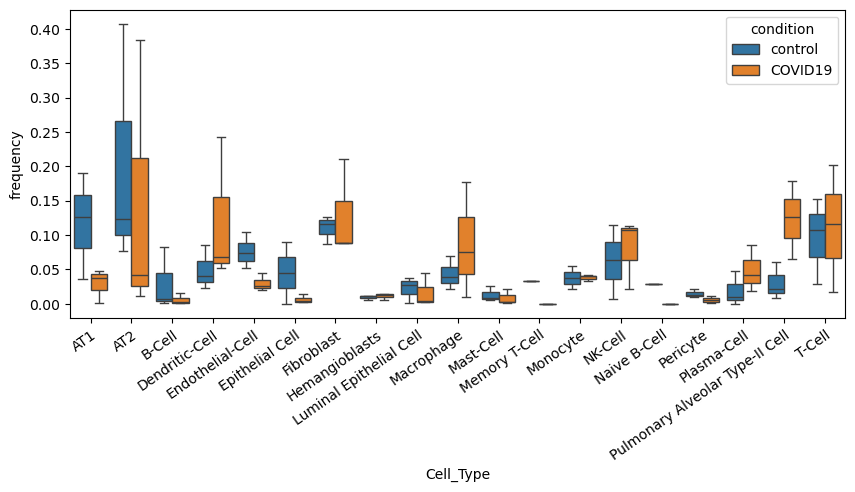

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
ax = sns.boxplot(data = cell_type_counts, x = 'Cell_Type', y = 'frequency', hue = 'condition')
plt.xticks(rotation=35, rotation_mode='anchor',ha = 'right')
plt.show()

## Differential Expression

### SCVI Method

In [118]:
subset = adata[adata.obs['Cell_Type'].isin(['AT1','AT2'])].copy()

In [119]:
# two options for DE. SCVI or diffxpy

In [120]:
model = scvi.model.SCVI.load('model.model', adata)

INFO     File model.model\model.pt already downloaded                                                              


c:\Users\agarc\anaconda3\envs\bioenv\Lib\site-packages\scvi\model\base\_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_locatio

In [121]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [122]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['Cell_Type'] == 'AT1'],
    idx2 = [adata.obs['Cell_Type'] == 'AT2']
)

# any set of cells (control) vs. any set of cells (COVID-19)
# scvi_de = model.differential_expression(
#    idx1 = [(adata.obs['Cell_Type'].isin(['AT1','AT2'])) & (adata.obs.condition == 'COVID19')],
#    idx2 = [(adata.obs['Cell_Type'].isin(['AT1','AT2'])) & (adata.obs.condition == 'control')]
#    )

DE...: 100%|██████████| 1/1 [00:43<00:00, 43.76s/it]


In [124]:
scvi_de

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
AUTS2     1.0000        0.0000     18.420681  0.000044  0.001365   
SCD5      1.0000        0.0000     18.420681  0.000448  0.000019   
TTLL7     1.0000        0.0000     18.420681  0.000429  0.000012   
EMP2      1.0000        0.0000     18.420681  0.003604  0.000254   
ANK3      1.0000        0.0000     18.420681  0.000431  0.003153   
...          ...           ...           ...       ...       ...   
ERC1      0.4256        0.5744     -0.299826  0.000407  0.000382   
MKLN1     0.3902        0.6098     -0.446472  0.000363  0.000374   
NIPBL     0.3896        0.6104     -0.448994  0.000415  0.000430   
PPP6R3    0.3892        0.6108     -0.450676  0.000309  0.000315   
NF1       0.3376        0.6624     -0.674008  0.000365  0.000369   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std   lfc_min  \
AUTS2            0.0   0.25 -5.211546   -5.253567  1.209296 -9.371141   
SCD5             0.0   0.25  4.887513    4.879807  1.264398  0.593095   
TTLL7            0.0   0.25  5.777374    5.743145  1.688777  0.356470   
EMP2             0.0   0.25  3.953140    3.978046  0.993432 -0.601017   
ANK3             0.0   0.25 -2.915529   -2.908741  0.751988 -5.831423   
...              ...    ...       ...         ...       ...       ...   
ERC1             0.0   0.25  0.099249    0.103234  0.291017 -1.163168   
MKLN1            0.0   0.25 -0.045094   -0.040483  0.297700 -1.288323   
NIPBL            0.0   0.25 -0.050540   -0.053280  0.284417 -0.959650   
PPP6R3           0.0   0.25 -0.024756   -0.029391  0.295347 -1.273718   
NF1              0.0   0.25 -0.010499    0.002179  0.289586 -1.523964   

          lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
AUTS2   -0.562826   0.060476   3.089007               0.040000   
SCD5     9.537418   0.806663   0.006986               0.431429   
TTLL7   11.064232   0.802376   0.017233               0.432381   
EMP2     7.895386   6.921938   0.316256               0.941905   
ANK3     0.303766   0.967613   7.514440               0.484762   
...           ...        ...        ...                    ...   
ERC1     1.469753   0.786186   0.732178               0.483333   
MKLN1    1.270876   0.682378   0.719836               0.431429   
NIPBL    1.103376   0.743329   0.777357               0.467619   
PPP6R3   1.125806   0.618093   0.602000               0.415238   
NF1      1.199845   0.665711   0.733343               0.434286   

        non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
AUTS2                0.805776              0.261003             16.554316   
SCD5                 0.005589              4.372207              0.036346   
TTLL7                0.014439              4.283333              0.073747   
EMP2                 0.214718             38.402008              1.562458   
ANK3                 0.942711              4.784137             38.218204   
...                       ...                   ...                   ...   
ERC1                 0.462739              4.349940              3.803312   
MKLN1                0.453889              3.607363              3.689191   
NIPBL                0.482534              4.081417              4.074309   
PPP6R3               0.412203              3.443462              3.240254   
NF1                  0.455286              3.656121              3.728960   

        is_de_fdr_0.05  
AUTS2             True  
SCD5              True  
TTLL7             True  
EMP2              True  
ANK3              True  
...                ...  
ERC1             False  
MKLN1            False  
NIPBL            False  
PPP6R3           False  
NF1              False  

[16471 rows x 19 columns]

In [125]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > 0.5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

proba_de  proba_not_de  bayes_factor        scale1        scale2  \
SFTPA1        0.9984        0.0016      6.436144  5.444317e-06  5.951187e-04   
DMBT1         0.9994        0.0006      7.417964  4.255679e-06  9.121521e-04   
NRGN          1.0000        0.0000     18.420681  4.249600e-07  8.011629e-05   
LRRC4C        0.9972        0.0028      5.875328  1.568513e-06  1.772210e-04   
SFTPA2        0.9978        0.0022      6.117091  9.568756e-06  7.227419e-04   
...              ...           ...           ...           ...           ...   
NCKAP5-AS2    0.9980        0.0020      6.212601  3.139665e-04  4.874390e-06   
HS3ST5        0.9994        0.0006      7.417964  8.674919e-05  1.037618e-06   
ROR1-AS1      0.9974        0.0026      5.949637  9.165636e-05  8.581964e-07   
AL355499.1    0.9992        0.0008      7.130086  1.321081e-03  1.533177e-05   
ANKRD1        0.9998        0.0002      8.516943  4.476154e-04  1.859919e-06   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
SFTPA1               0.0   0.25 -8.868646   -9.066427  2.865515 -18.341225   
DMBT1                0.0   0.25 -8.771050   -8.864898  2.752377 -17.463936   
NRGN                 0.0   0.25 -8.540417   -8.527843  2.393439 -16.291018   
LRRC4C               0.0   0.25 -8.432836   -8.394563  3.479583 -19.632259   
SFTPA2               0.0   0.25 -8.174623   -8.410949  2.970921 -19.626249   
...                  ...    ...       ...         ...       ...        ...   
NCKAP5-AS2           0.0   0.25  7.595049    7.723884  2.783794  -3.664638   
HS3ST5               0.0   0.25  7.750204    7.785559  2.637769  -1.325224   
ROR1-AS1             0.0   0.25  8.491144    8.596619  3.375951  -5.800729   
AL355499.1           0.0   0.25  8.932032    8.665370  3.491514  -1.174801   
ANKRD1               0.0   0.25  9.973182   10.002468  3.330056  -0.546182   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
SFTPA1       5.358079   0.004762   1.487900               0.000952   
DMBT1        1.386786   0.000952   1.371687               0.000952   
NRGN         0.301626   0.000476   0.142757               0.000476   
LRRC4C       3.670656   0.000000   0.219143               0.000000   
SFTPA2       6.346459   0.017143   1.880075               0.001905   
...               ...        ...        ...                    ...   
NCKAP5-AS2  15.518972   0.848568   0.000233               0.346667   
HS3ST5      17.270235   0.188095   0.000699               0.140476   
ROR1-AS1    19.574120   0.218096   0.000466               0.150000   
AL355499.1  25.549219   2.163341   0.000699               0.708095   
ANKRD1      21.624582   0.670475   0.000932               0.173333   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
SFTPA1                   0.414765              0.010193              6.835813   
DMBT1                    0.363996              0.004884              7.503570   
NRGN                     0.117140              0.002024              0.813281   
LRRC4C                   0.068468              0.000000              0.958022   
SFTPA2                   0.357243              0.047501              8.220757   
...                           ...                   ...                   ...   
NCKAP5-AS2               0.000233              3.817780              0.000709   
HS3ST5                   0.000699              0.945503              0.003785   
ROR1-AS1                 0.000466              1.012712              0.001563   
AL355499.1               0.000233             11.632881              0.001875   
ANKRD1                   0.000233              4.012448              0.001905   

            is_de_fdr_0.05  
SFTPA1                True  
DMBT1                 True  
NRGN                  True  
LRRC4C                True  
SFTPA2                True  
...                    ...  
NCKAP5-AS2            True  
HS3ST5                True  
ROR1-AS1              True  
AL355499.1

In [126]:
# filter out 'raw_normalized_mean' that is low in both groups
scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > 0.5) | (scvi_de.raw_normalized_mean2 > 0.5)]
scvi_de

proba_de  proba_not_de  bayes_factor        scale1        scale2  \
SFTPA1        0.9984        0.0016      6.436144  5.444317e-06  5.951187e-04   
DMBT1         0.9994        0.0006      7.417964  4.255679e-06  9.121521e-04   
NRGN          1.0000        0.0000     18.420681  4.249600e-07  8.011629e-05   
LRRC4C        0.9972        0.0028      5.875328  1.568513e-06  1.772210e-04   
SFTPA2        0.9978        0.0022      6.117091  9.568756e-06  7.227419e-04   
...              ...           ...           ...           ...           ...   
NCKAP5-AS2    0.9980        0.0020      6.212601  3.139665e-04  4.874390e-06   
HS3ST5        0.9994        0.0006      7.417964  8.674919e-05  1.037618e-06   
ROR1-AS1      0.9974        0.0026      5.949637  9.165636e-05  8.581964e-07   
AL355499.1    0.9992        0.0008      7.130086  1.321081e-03  1.533177e-05   
ANKRD1        0.9998        0.0002      8.516943  4.476154e-04  1.859919e-06   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
SFTPA1               0.0   0.25 -8.868646   -9.066427  2.865515 -18.341225   
DMBT1                0.0   0.25 -8.771050   -8.864898  2.752377 -17.463936   
NRGN                 0.0   0.25 -8.540417   -8.527843  2.393439 -16.291018   
LRRC4C               0.0   0.25 -8.432836   -8.394563  3.479583 -19.632259   
SFTPA2               0.0   0.25 -8.174623   -8.410949  2.970921 -19.626249   
...                  ...    ...       ...         ...       ...        ...   
NCKAP5-AS2           0.0   0.25  7.595049    7.723884  2.783794  -3.664638   
HS3ST5               0.0   0.25  7.750204    7.785559  2.637769  -1.325224   
ROR1-AS1             0.0   0.25  8.491144    8.596619  3.375951  -5.800729   
AL355499.1           0.0   0.25  8.932032    8.665370  3.491514  -1.174801   
ANKRD1               0.0   0.25  9.973182   10.002468  3.330056  -0.546182   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
SFTPA1       5.358079   0.004762   1.487900               0.000952   
DMBT1        1.386786   0.000952   1.371687               0.000952   
NRGN         0.301626   0.000476   0.142757               0.000476   
LRRC4C       3.670656   0.000000   0.219143               0.000000   
SFTPA2       6.346459   0.017143   1.880075               0.001905   
...               ...        ...        ...                    ...   
NCKAP5-AS2  15.518972   0.848568   0.000233               0.346667   
HS3ST5      17.270235   0.188095   0.000699               0.140476   
ROR1-AS1    19.574120   0.218096   0.000466               0.150000   
AL355499.1  25.549219   2.163341   0.000699               0.708095   
ANKRD1      21.624582   0.670475   0.000932               0.173333   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
SFTPA1                   0.414765              0.010193              6.835813   
DMBT1                    0.363996              0.004884              7.503570   
NRGN                     0.117140              0.002024              0.813281   
LRRC4C                   0.068468              0.000000              0.958022   
SFTPA2                   0.357243              0.047501              8.220757   
...                           ...                   ...                   ...   
NCKAP5-AS2               0.000233              3.817780              0.000709   
HS3ST5                   0.000699              0.945503              0.003785   
ROR1-AS1                 0.000466              1.012712              0.001563   
AL355499.1               0.000233             11.632881              0.001875   
ANKRD1                   0.000233              4.012448              0.001905   

            is_de_fdr_0.05  
SFTPA1                True  
DMBT1                 True  
NRGN                  True  
LRRC4C                True  
SFTPA2                True  
...                    ...  
NCKAP5-AS2            True  
HS3ST5                True  
ROR1-AS1              True  
AL355499.1

In [127]:
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist() #get the top 25 and bottom 25 from sorted scvi_de df.

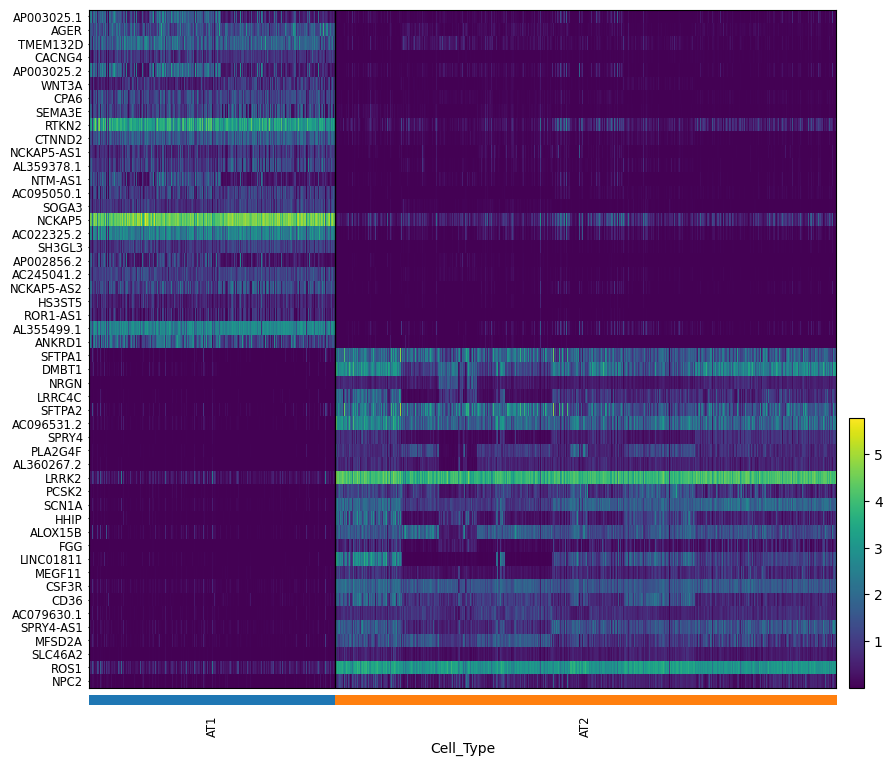

In [128]:
sc.pl.heatmap(subset, genes_to_show, groupby='Cell_Type', swap_axes=True, layer='scvi_normalized', log=True)

### Diffxpy Method

In [137]:
subset = adata[adata.obs['Cell_Type'].isin(['AT1', 'AT2'])].copy()

In [146]:
import diffxpy.api as de

In [147]:
subset.X = subset.X.toarray()

In [148]:
len(subset.var)

16471

In [149]:
sc.pp.filter_genes(subset, min_cells=100)

In [150]:
# if you want to test COVID vs. control
#   res = de.test.wald(data=subset,
#                       formula_loc='~1 + condition',
#                       factor_loc_totest='condition')

# mimick the paper and do AT1 vs AT2
res = de.test.wald(data=subset,
                   formula_loc='~1 + Cell_Type',
                   factor_loc_totest = 'Cell_Type')

training location model: False
training scale model: True
iter   0: ll=192596227.949942
iter   1: ll=192596227.949942, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 9634 dispersion models: (progress not available with multiprocessing)

## Gene Ontology Enrichment

In [130]:
import gseapy as gp

In [131]:
gp.get_library_name()

# 'GO_Biological_Process_2021'
# 'KEGG_2021_Human'

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [132]:
subset

AnnData object with n_obs × n_vars = 6394 × 16471
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'Cell_Type', 'condition'
    var: 'n_cells'
    uns: 'Cell_Type_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [135]:
scvi_de[scvi_de.log2fc > 0].gene.tolist()

AttributeError: 'DataFrame' object has no attribute 'log2fc'